In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller              
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.ar_model
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
calendar = pd.read_csv('/content/drive/MyDrive/INFO-VIZ/calendar.csv')
sales= pd.read_csv('/content/drive/MyDrive/INFO-VIZ/sales_train_evaluation.csv')
sell_prices = pd.read_csv('/content/drive/MyDrive/INFO-VIZ/sell_prices.csv')

In [ ]:
print("The shape of sales data:",sales.shape)
print("The shape of sell_prices data:",sell_prices.shape)
print("The shape of calender data:",calendar.shape)

The shape of sales data: (30490, 1947)
The shape of sell_prices data: (6841121, 4)
The shape of calender data: (1969, 14)


In [ ]:
calendar.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
# Merging with sell price - Deprioritized due to long execution time

# cal = calendar.copy()
# cal["d"] = cal["d"].apply(lambda a: int(a.split("_")[1]))
# df_sales = sales
# from tqdm import tqdm
# for day in tqdm(range(1,1942)):  
#   wk_id=list(cal[cal["d"]==day]["wm_yr_wk"])[0]
#   wk_price = sell_prices[sell_prices["wm_yr_wk"]==wk_id]
#   df_sales = df_sales.merge(wk_price, on=["store_id","item_id"], how='left')
#   df_sales["sp_" + str(day)] = df_sales["sell_price"]
#   df_sales.drop(columns=["sell_price","wm_yr_wk"], inplace=True)

# print(sales.shape, df_sales.shape)
# df_sales

In [ ]:
df_sales.isna().sum()

# Data Prep Phase

## Perform Downcasting to reduce the amount of storage used by the datframes

In [ ]:
# UPDATE 10/29 SS

def checkMemUsage(df):
  """
  Helper function to check memory usage

  Input: A dataframe

  Output: Memory usage

  """
  mem_usage = df.memory_usage().sum()
  return np.round(np.round(mem_usage/(1024*1024),1))

In [ ]:
# Memory Usage Before Downcasting

print("Initial Memoery Usage: Sales {} , Calendar {} , sell_prices {}".format(checkMemUsage(sales), checkMemUsage(calendar), checkMemUsage(sell_prices)))
                                                                    

Initial Memoery Usage: Sales 453.0 , Calendar 0.0 , sell_prices 209.0


In [ ]:
# UPDATE 10/29 SS

def performDowncast(df):

  """
  Function tpo apply downcasting 
  
  Input: A dataframe 

  Output: Dataframe with reduced memory usage
  
  
  """
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()

  for idx,dtype in enumerate(types):

      if 'int' in str(dtype):  # Downcasting for Int type variables
          if df[cols[idx]].min() > np.iinfo(np.int8).min and df[cols[idx]].max() < np.iinfo(np.int8).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int8) # Downsize to int8
          elif df[cols[idx]].min() > np.iinfo(np.int16).min and df[cols[idx]].max() < np.iinfo(np.int16).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int16) # Downsize to int16
          elif df[cols[idx]].min() > np.iinfo(np.int32).min and df[cols[idx]].max() < np.iinfo(np.int32).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int32) # Downsize to int32
          else:
              df[cols[idx]] = df[cols[idx]].astype(np.int64) # Downsize as int64

      elif 'float' in str(dtype): # Downcasting for Float type variables
          if df[cols[idx]].min() > np.finfo(np.float16).min and df[cols[idx]].max() < np.finfo(np.float16).max:
              df[cols[idx]] = df[cols[idx]].astype(np.float16) # Downsize to float16
          elif df[cols[idx]].min() > np.finfo(np.float32).min and df[cols[idx]].max() < np.finfo(np.float32).max:
              df[cols[idx]] = df[cols[idx]].astype(np.float32) # Downsize to float32
          else:
              df[cols[idx]] = df[cols[idx]].astype(np.float64) # Downsize to float64

      elif dtype == np.object: # By default strings are treated as objects
          if cols[idx] == 'date':
              df[cols[idx]] = pd.to_datetime(df[cols[idx]], format='%Y-%m-%d')
          # else:
          #     df[cols[idx]] = df[cols[idx]].astype('category')

  return df

In [ ]:
sales = performDowncast(sales)
calendar = performDowncast(calendar)
sell_prices = performDowncast(sell_prices)

print("Memory Usage after Downcasting: Sales {} , Calendar {} , sell_prices {}".format(checkMemUsage(sales), checkMemUsage(calendar), checkMemUsage(sell_prices)))

Memory Usage after Downcasting: Sales 96.0 , Calendar 0.0 , sell_prices 130.0


In [ ]:
sales.head() # QC check to verify the original data is not changed

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
calendar.head() # QC check to verify the original data is not changed

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
sell_prices.head() # QC check to verify the original data is not changed

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


## Perform Groupby across sales data to identify best selection

In [ ]:
sales_item = sales.groupby('item_id').sum()
sales_item.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15.0,16,18,11.0,10.0,12.0,7.0,17.0,9,9.0,8.0,5,14.0,26.0,8.0,12.0,13,5.0,11.0,10.0,14.0,11.0,8,22,14.0,6.0,9.0,...,6.0,3,4,4,30,7.0,5.0,3.0,6.0,2,16,6,4,5.0,7.0,1.0,9,3,9.0,1.0,10,3.0,1.0,6,10,6,2.0,5.0,6.0,2.0,7,8,8,4.0,7.0,7.0,5.0,7.0,5,9.0
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5.0,8,5,1.0,3.0,2.0,0.0,4.0,5,4.0,2.0,2,4.0,3.0,5.0,7.0,3,3.0,4.0,7.0,7.0,3.0,4,11,0.0,1.0,1.0,...,5.0,4,5,9,4,1.0,3.0,5.0,5.0,3,3,1,9,4.0,3.0,4.0,5,7,2.0,5.0,6,3.0,2.0,4,5,3,1.0,6.0,3.0,10.0,5,8,7,2.0,6.0,5.0,0.0,6.0,6,4.0
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17.0,20,14,10.0,9.0,3.0,14.0,7.0,23,16.0,7.0,12,6.0,5.0,7.0,10.0,6,10.0,6.0,8.0,3.0,9.0,18,18,11.0,8.0,4.0,...,4.0,1,7,3,5,6.0,3.0,4.0,4.0,3,11,5,7,13.0,9.0,1.0,2,4,7.0,9.0,2,3.0,13.0,5,9,5,0.0,6.0,3.0,10.0,7,8,6,11.0,9.0,7.0,7.0,10.0,6,5.0
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,15.0,33.0,67.0,118,101,132.0,119.0,156,116.0,144.0,150,173,152,123.0,100.0,95.0,112.0,115,104,107,81.0,73.0,62.0,71.0,75.0,83,93.0
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,16,23,30,21.0,45,61,27.0,20.0,13.0,13.0,17.0,26,30.0,34.0,14,36.0,25.0,9.0,37.0,39,18.0,13.0,18.0,19.0,17.0,24,40,16.0,15.0,7.0,...,25.0,24,16,14,14,18.0,18.0,27.0,12.0,15,38,9,14,9.0,27.0,14.0,14,33,19.0,17.0,11,16.0,18.0,29,28,13,25.0,10.0,19.0,12.0,15,16,25,9.0,7.0,25.0,19.0,25.0,17,19.0


In [ ]:
sales_dept = sales.groupby('dept_id').sum()
sales_dept.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,1785,1737,2048,2349.0,2948,3688,2193.0,1552.0,1617.0,1502.0,1866.0,2391,2164.0,1784.0,1480,1587.0,1542.0,1744.0,2432.0,2019,1464.0,1691.0,1588.0,1626.0,1759.0,2193,2301,1540.0,1456.0,1482.0,...,2591.0,2583,3192,3523,3062,2461.0,2544.0,2657.0,2639.0,3169,3712,3185,2841,2860.0,2799.0,3184.0,3800,4415,4285.0,3506.0,4020,3602.0,3759.0,3925,4951,3895,3417.0,3306.0,3262.0,3252.0,4130,4257,4225,3264.0,3119.0,3073.0,3251.0,3735.0,4195,4031.0
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,3255,3696,3592,3743.0,4722,4889,3021.0,3899.0,3219.0,2790.0,3030.0,3821,3853.0,3184.0,2598,2548.0,2463.0,2648.0,3499.0,3881,3028.0,3344.0,3245.0,3472.0,3310.0,4432,5162,3709.0,3480.0,3460.0,...,5124.0,5518,5661,5792,6588,5247.0,4942.0,4734.0,4446.0,4974,5524,6473,4957,4662.0,4111.0,4089.0,4973,5781,7129.0,6384.0,6296,5410.0,5906.0,5897,6997,6188,7531.0,5873.0,6537.0,5982.0,5842,7563,9069,6226.0,5311.0,4648.0,4551.0,4815.0,5940,6535.0
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,11923,12222,11700,12946.0,17517,18079,10801.0,11974.0,10515.0,9998.0,11698.0,14726,14011.0,11405.0,9965,9797.0,9728.0,11088.0,13974.0,14760,10574.0,11533.0,11385.0,12144.0,12443.0,16447,17446,12339.0,11344.0,11097.0,...,16173.0,17355,19829,22692,24847,18443.0,17462.0,16241.0,16232.0,18561,22691,22996,18155,15997.0,15962.0,15642.0,18895,22527,23955.0,19252.0,19278,18187.0,18528.0,20585,24804,21752,21958.0,18152.0,19504.0,18908.0,20135,24756,28153,19668.0,17718.0,17069.0,16935.0,19586.0,23464,25401.0
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,2412,2355,2524,2698.0,3567,3221,2106.0,2389.0,2031.0,1915.0,2131.0,3985,2809.0,2532.0,2344,2619.0,2424.0,2505.0,3918.0,1917,1595.0,1666.0,1507.0,1738.0,1480.0,1881,3579,2512.0,2363.0,2787.0,...,3182.0,3366,3367,4220,4325,3038.0,3420.0,3141.0,3014.0,3678,4397,4226,3389,3217.0,3236.0,3253.0,3649,4627,4322.0,3595.0,3907,3190.0,3195.0,3412,4448,3606,3514.0,3172.0,3384.0,3256.0,3422,4414,4464,3109.0,3142.0,3291.0,3027.0,3761.0,4832,4720.0
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,135,102,176,124.0,132,196,127.0,165.0,139.0,134.0,153.0,157,169.0,203.0,115,139.0,135.0,170.0,170.0,201,176.0,167.0,168.0,117.0,173.0,215,216,175.0,156.0,168.0,...,375.0,420,419,414,495,285.0,367.0,331.0,339.0,407,390,457,393,428.0,494.0,489.0,436,587,536.0,464.0,466,518.0,607.0,467,555,456,381.0,416.0,433.0,450.0,449,479,552,419.0,487.0,449.0,448.0,382.0,501,560.0


In [ ]:
sales_store = sales.groupby('store_id').sum()
sales_store.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078.0,4316,4354,2757.0,2430.0,2272.0,2009.0,3015.0,4553,3966.0,3264.0,2441,2377.0,2414.0,2701.0,3719.0,3548,2246.0,2549.0,2559.0,2568.0,2978.0,4096,4832,3138.0,2997.0,2772.0,...,3478.0,3637,3982,5437,5954,4345.0,3793.0,3722.0,3709.0,4387,5577,6113,4472,3703.0,3715.0,3618.0,4573,5898,6397.0,4794.0,4594,4234.0,3918.0,4804,6069,5212,4859.0,4104.0,3982.0,4049.0,4951,6245,6707,4568.0,3949.0,3995.0,4136.0,4433.0,5764,6289.0
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,2123,1901,2436,2584.0,3455,3563,1801.0,1797.0,1741.0,1614.0,2214.0,3080,3087.0,2601.0,1810,1851.0,1652.0,2187.0,3516.0,2692,1894.0,1958.0,1837.0,2010.0,2105.0,3199,3272,1970.0,1800.0,2064.0,...,3545.0,3441,4440,5352,5760,3830.0,3631.0,3691.0,3303.0,4457,5884,6082,3926,3525.0,3527.0,3754.0,4382,6349,6193.0,4434.0,3977,4243.0,4020.0,4492,6636,5330,3999.0,4092.0,3722.0,3751.0,4839,6507,6710,4238.0,3963.0,3789.0,4037.0,4751.0,7120,6614.0
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,4447,4544,4406,4380.0,5187,5780,3303.0,3758.0,3641.0,3099.0,3320.0,4694,4794.0,4631.0,3593,3342.0,3310.0,3575.0,4774.0,4540,3604.0,3846.0,3821.0,3757.0,3904.0,4894,5895,4274.0,4084.0,3754.0,...,5377.0,5493,5337,6936,8271,6068.0,5683.0,5235.0,5018.0,5623,7419,7721,6359,5289.0,5065.0,5015.0,5705,7057,7828.0,6776.0,6325,6204.0,5793.0,5842,7346,6743,6958.0,5960.0,5884.0,5039.0,6046,7029,7969,5891.0,5523.0,5375.0,5580.0,5542.0,7073,8144.0
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,1368,1195,1434,1312.0,1652,1933,1183.0,1511.0,1190.0,1113.0,1476.0,1543,1618.0,1501.0,1286,1371.0,1138.0,1384.0,1643.0,1711,1452.0,1429.0,1320.0,1375.0,1457.0,1595,2058,1571.0,1418.0,1361.0,...,2214.0,2498,2496,2839,3047,2809.0,2677.0,2500.0,2458.0,2628,2954,3271,2767,2495.0,2529.0,2277.0,2520,3023,3271.0,3113.0,2934,2585.0,2466.0,2500,3068,2675,3100.0,2815.0,2603.0,2659.0,2635,3256,3318,3024.0,2715.0,2519.0,2544.0,2704.0,3146,3597.0
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,1607,2149,1895,2256.0,2944,3432,1921.0,2217.0,1962.0,1821.0,1951.0,2571,2810.0,2071.0,1933,1723.0,1825.0,1886.0,2629.0,2688,1985.0,1967.0,1860.0,2052.0,1753.0,2642,3031,2272.0,1788.0,2180.0,...,2852.0,2924,3084,3724,4192,3410.0,3257.0,2901.0,2776.0,3022,3700,4033,3076,2853.0,2984.0,2664.0,3687,4052,4412.0,2859.0,3217,2839.0,3170.0,3428,4123,3196,3437.0,3020.0,3398.0,3351.0,3610,3787,5000,3708.0,3310.0,3147.0,2748.0,3664.0,4167,4624.0


In [ ]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178.0,3764.0,5689.0
d_2,22758.0,3357.0,5634.0
d_3,17174.0,2682.0,3927.0
d_4,18878.0,2669.0,3865.0
d_5,14603.0,1814.0,2729.0


In [ ]:
# UPDATE 10/28 SS

sales_dept = sales.groupby('dept_id').sum().T
sales_dept.head()

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
d_1,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0
d_2,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0
d_3,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0
d_4,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0
d_5,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0


In [ ]:
sales_cat['days'] = sales_cat.index

In [ ]:
sales_cat.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD,days
d_1,23178.0,3764.0,5689.0,d_1
d_2,22758.0,3357.0,5634.0,d_2
d_3,17174.0,2682.0,3927.0,d_3
d_4,18878.0,2669.0,3865.0,d_4
d_5,14603.0,1814.0,2729.0,d_5


In [ ]:
print(calendar.event_name_1.count(), calendar.event_type_1.count(), calendar.event_name_2.count(), calendar.event_type_2.count())

162 162 5 5


In [ ]:
# UPDATE 10/29 SS

sales_calender = calendar.iloc[:,[0,2,3,4,5,6,8,10,11,12,13]]  # Including all special day events
print(sales_calender.shape)
sales_calender.head(10)

(1969, 11)


,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1
5,2011-02-03,Thursday,6,2,2011,d_6,NaN,NaN,1,1,1
6,2011-02-04,Friday,7,2,2011,d_7,NaN,NaN,1,0,0
7,2011-02-05,Saturday,1,2,2011,d_8,NaN,NaN,1,1,1
8,2011-02-06,Sunday,2,2,2011,d_9,Sporting,NaN,1,1,1
9,2011-02-07,Monday,3,2,2011,d_10,NaN,NaN,1,1,0


In [ ]:
#sales_calender = calendar.iloc[:,[0,2,3,4,5,6,7]]
print(sales_cat.shape, sales_calender.shape)
sales_cat = pd.merge(sales_calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')
sales_cat['date'] = pd.to_datetime(sales_cat['date'])

(1941, 4) (1969, 11)


In [ ]:
print(sales_cat.shape)
sales_cat.head()

(1941, 15)


,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5


In [ ]:
sales_cat = sales_cat.set_index('date')

In [ ]:
sales_cat.head()

,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days
date,,,,,,,,,,,,,,
2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1
2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2
2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3
2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4
2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5


In [ ]:
sales_cat['weekday'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [ ]:
print(sales_cat.event_type_1.unique())
print(sales_cat.event_type_2.unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Cultural' 'Religious']


## Creating exogenous variables from within the data

In [ ]:
sales_cat["isWeekend"] = [1 if d =="Saturday" or d == "Sunday" else 0 for d in sales_cat.weekday] # To capture weekend sales
sales_cat["isWeekday"] = [0 if d =="Saturday" or d == "Sunday" else 1 for d in sales_cat.weekday] # To capture weekday sales
sales_cat['inbetween25and5'] = [1 if d >= 25 or d <= 5 else 0 for d in sales_cat.index.day] # Usual Payday
sales_cat['event_on_weekend'] = [1 if (wknd == 1 and (event1 not in [np.nan] or event2 not in [np.nan])) else 0 for wknd, event1, event2 in  
                              sales_cat[['isWeekend','event_type_1','event_type_2']].values] # If event was on weekends
sales_cat['event_on_weekday'] = [1 if (wkday == 1 and (event1 not in [np.nan] or event2 not in [np.nan])) else 0 for wkday, event1, event2 in
                              sales_cat[['isWeekday','event_type_1','event_type_2']].values] # If event was on weekdays

sales_cat = pd.get_dummies(sales_cat, columns=['event_type_1','event_type_2'], 
                             prefix=['event_type_1','event_type_2'], 
                             dummy_na=False)  # Dummy variable for all the events

sales_cat
print(sales_cat.shape)
sales_cat.head(10)

(1941, 23)


,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days,isWeekend,isWeekday,inbetween25and5,event_on_weekend,event_on_weekday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,Saturday,1,1,2011,d_1,0,0,0,23178.0,3764.0,5689.0,d_1,1,0,1,0,0,0,0,0,0,0,0
2011-01-30,Sunday,2,1,2011,d_2,0,0,0,22758.0,3357.0,5634.0,d_2,1,0,1,0,0,0,0,0,0,0,0
2011-01-31,Monday,3,1,2011,d_3,0,0,0,17174.0,2682.0,3927.0,d_3,0,1,1,0,0,0,0,0,0,0,0
2011-02-01,Tuesday,4,2,2011,d_4,1,1,0,18878.0,2669.0,3865.0,d_4,0,1,1,0,0,0,0,0,0,0,0
2011-02-02,Wednesday,5,2,2011,d_5,1,0,1,14603.0,1814.0,2729.0,d_5,0,1,1,0,0,0,0,0,0,0,0
2011-02-03,Thursday,6,2,2011,d_6,1,1,1,22093.0,3220.0,3898.0,d_6,0,1,1,0,0,0,0,0,0,0,0
2011-02-04,Friday,7,2,2011,d_7,1,0,0,20490.0,2944.0,4576.0,d_7,0,1,1,0,0,0,0,0,0,0,0
2011-02-05,Saturday,1,2,2011,d_8,1,1,1,27751.0,3986.0,6195.0,d_8,1,0,1,0,0,0,0,0,0,0,0
2011-02-06,Sunday,2,2,2011,d_9,1,1,1,24862.0,2899.0,4975.0,d_9,1,0,0,1,0,0,0,0,1,0,0


In [ ]:
sales_cat.drop(['weekday','wday','month','year','d','days'],axis=1,inplace=True)
sales_cat.head()

,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,isWeekend,isWeekday,inbetween25and5,event_on_weekend,event_on_weekday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,23178.0,3764.0,5689.0,1,0,1,0,0,0,0,0,0,0,0
2011-01-30,0,0,0,22758.0,3357.0,5634.0,1,0,1,0,0,0,0,0,0,0,0
2011-01-31,0,0,0,17174.0,2682.0,3927.0,0,1,1,0,0,0,0,0,0,0,0
2011-02-01,1,1,0,18878.0,2669.0,3865.0,0,1,1,0,0,0,0,0,0,0,0
2011-02-02,1,0,1,14603.0,1814.0,2729.0,0,1,1,0,0,0,0,0,0,0,0


In [ ]:
sales_cat.iloc[:,3:-1]

,FOODS,HOBBIES,HOUSEHOLD,isWeekend,isWeekday,inbetween25and5,event_on_weekend,event_on_weekday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural
date,,,,,,,,,,,,,
2011-01-29,23178.0,3764.0,5689.0,1,0,1,0,0,0,0,0,0,0
2011-01-30,22758.0,3357.0,5634.0,1,0,1,0,0,0,0,0,0,0
2011-01-31,17174.0,2682.0,3927.0,0,1,1,0,0,0,0,0,0,0
2011-02-01,18878.0,2669.0,3865.0,0,1,1,0,0,0,0,0,0,0
2011-02-02,14603.0,1814.0,2729.0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,24790.0,3740.0,8566.0,0,1,0,0,0,0,0,0,0,0
2016-05-19,24737.0,3475.0,8751.0,0,1,0,0,0,0,0,0,0,0
2016-05-20,28136.0,4143.0,10273.0,0,1,0,0,0,0,0,0,0,0


# Timeseries Analysis

In [ ]:
def resampleData(inputData, type="D"):
  """
  Helper Function to resample Data 

  Input: 
    inputData: Sales Data
    type: Parameter for daily, weekly or monthly

  Output: Resampled data with aggregated sales
  """
  if type=="W":
    return inputData.iloc[:,3:-1].resample('W').sum()[8:-1] 
    #return inputData.resample('W').sum()[8:-1] 
  elif type=="D":
    return inputData.iloc[:,3:-1].resample('D').sum()
  elif type=="M":
    return inputData.iloc[:,3:-1].resample('M').sum()

# Phase 1: Resampled Weekly


In [ ]:
sales_cat_weekly = resampleData(sales_cat.copy(),"W") #weekly resampling

# Necessary data cleaning required for weekly aggregation

sales_cat_weekly.drop(['isWeekend','isWeekday'],axis=1,inplace=True)  # Dropping as not relevant for weekly aggregated data
sales_cat_weekly.iloc[:,3:-1] = sales_cat_weekly.iloc[:,3:-1].clip(upper=1) # Setting the max upper bounds for relevant exog variables to 1
#sales_cat_weekly.iloc[:,6:-1] = sales_cat_weekly.iloc[:,6:-1].clip(upper=1)
#sales_cat_weekly.iloc[:,0:3] = sales_cat_weekly.iloc[:,0:3].clip(upper=1)

In [ ]:
sales_cat_weekly

,FOODS,HOBBIES,HOUSEHOLD,inbetween25and5,event_on_weekend,event_on_weekday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural
date,,,,,,,,,,,
2011-03-27,111979.0,19833.0,32701.0,1,0,0,0,0,0,0,0
2011-04-03,121015.0,21793.0,33737.0,1,0,0,0,0,0,0,0
2011-04-10,129467.0,20335.0,32223.0,1,0,0,0,0,0,0,0
2011-04-17,123350.0,19998.0,32777.0,0,0,0,0,0,0,0,0
2011-04-24,110804.0,17479.0,31408.0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-04-17,201045.0,27683.0,67281.0,0,0,0,0,0,0,0,0
2016-04-24,189333.0,27490.0,68456.0,0,0,0,0,0,0,0,0
2016-05-01,191019.0,29056.0,69739.0,1,1,0,0,0,1,0,0


In [ ]:

lists = ['FOODS','HOBBIES','HOUSEHOLD']
exog_list = list(set(sales_cat_weekly.columns)-set(lists))
def plotSeries(inputData,lists=lists):
  """
  Helper Function to plot Time Series

  Input:
    inputData: Resampled Dataframe
    lists: category/department names

  Output:
    Timeseries plot

  """
  for i in lists:
        fig = go.Figure(data = [
              go.Scatter(y = inputData[i],x = inputData[i].index,name = i)
        ])
        fig.update_layout(title_text=i)
        fig.show()

In [ ]:
exog_list

['inbetween25and5',
 'event_on_weekday',
 'event_on_weekend',
 'event_type_1_Sporting',
 'event_type_2_Cultural',
 'event_type_1_Cultural',
 'event_type_1_Religious',
 'event_type_1_National']

In [ ]:
plotSeries(sales_cat_weekly,lists)

Seasonal Decompose on Weekly Resampled Sales


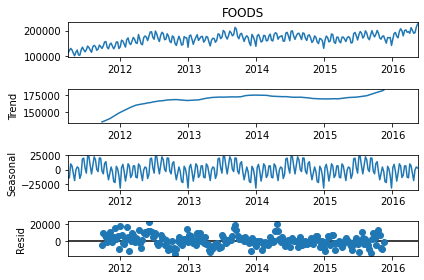

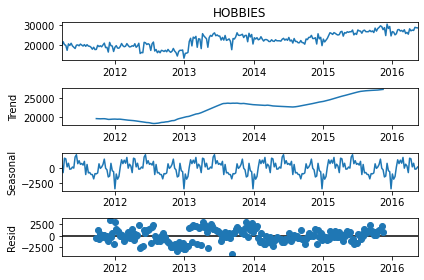

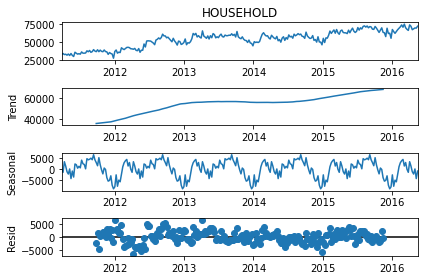

In [ ]:
print('Seasonal Decompose on Weekly Resampled Sales')

for i in lists:
    
    sm.tsa.seasonal_decompose(sales_cat_weekly[i]).plot()
    #fig.update_layout(title_text=i)

**ADF TEST FOR ALL CATEGORIES and PLOTS FOR ACF AND PACF**

In [ ]:
def performADFTest(inputData, lists=lists):
  """
  Helper Function to perform ADF Test for non-stationarity tests

  Input:
    inputData: Resampled Data
    lists: category/department names

  Output:
    Test Results
      Interpretation: p-value > 0.05 indicates failure to reject null hypothesis i.e, series is non-stationary

  """

  for i in lists:

    print('Results of Dickey-Fuller Test for : ',i)
    dftest = adfuller(inputData[i])

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = round(value,2)

    print(dfoutput)
    print('++++++++++++++++++++++++++++++++++++++')
    print('\n')

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
    ax1 = plot_acf(inputData[i], lags=50, ax=ax1)
    ax2 = plot_pacf(inputData[i], lags=50, ax=ax2)
    plt.show()

Results of Dickey-Fuller Test for :  FOODS
Test Statistic                  -2.042534
p-value                          0.268240
#Lags Used                      16.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.460000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




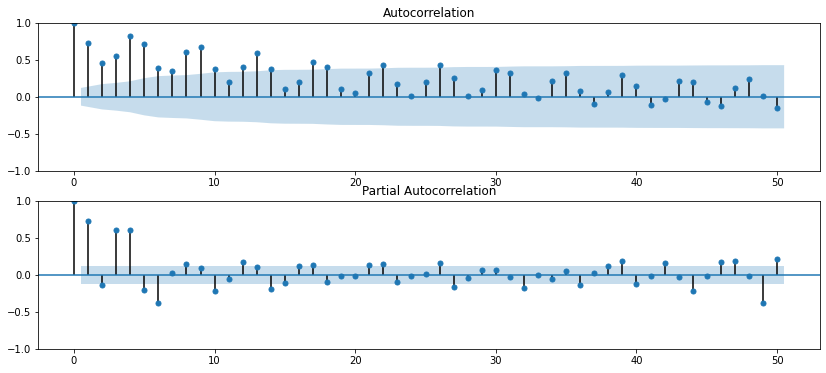

Results of Dickey-Fuller Test for :  HOBBIES
Test Statistic                  -1.418464
p-value                          0.573393
#Lags Used                       3.000000
Number of Observations Used    265.000000
Critical Value (1%)             -3.460000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




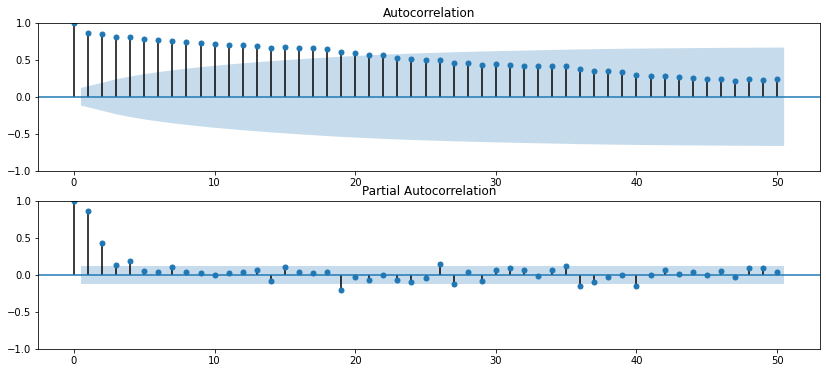

Results of Dickey-Fuller Test for :  HOUSEHOLD
Test Statistic                  -1.323889
p-value                          0.618173
#Lags Used                      12.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.460000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




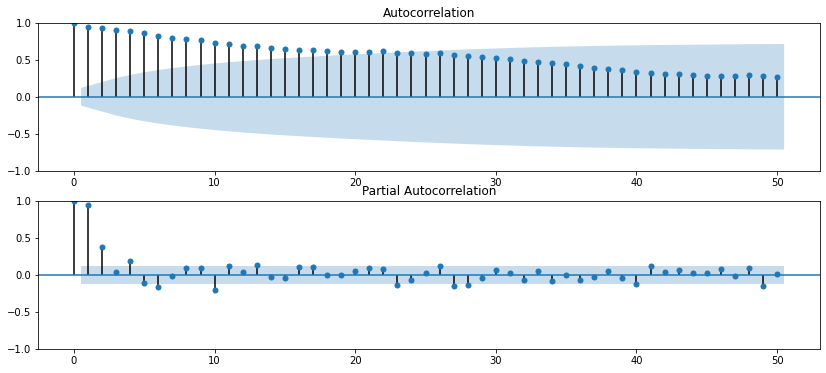

In [ ]:
performADFTest(sales_cat_weekly)

In [ ]:
sales_cat_weekly_food = sales_cat_weekly['FOODS']
sales_cat_weekly_house = sales_cat_weekly['HOUSEHOLD']
sales_cat_weekly_hobbies = sales_cat_weekly['HOBBIES']

In [ ]:
# Apply differentiation based on ACF - PACF plots

sales_cat_weekly_food_diff = sales_cat_weekly_food.diff(2)
sales_cat_weekly_house_diff = sales_cat_weekly_house.diff(1)
sales_cat_weekly_hobbies_diff = sales_cat_weekly_hobbies.diff(1)
sales_cat_weekly_food_diff = sales_cat_weekly_food_diff.dropna()
sales_cat_weekly_house_diff = sales_cat_weekly_house_diff.dropna()
sales_cat_weekly_hobbies_diff = sales_cat_weekly_hobbies_diff.dropna()

Results of Dickey-Fuller Test for :  FOODS
Test Statistic                  -4.641156
p-value                          0.000108
#Lags Used                      13.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.460000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




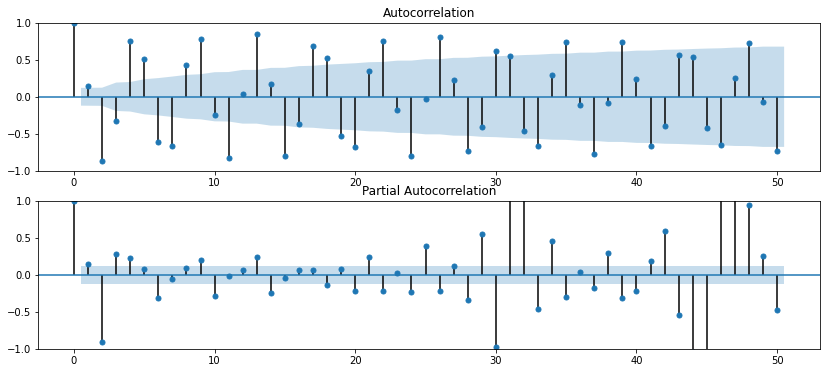

Results of Dickey-Fuller Test for :  HOUSEHOLD
Test Statistic                -6.607054e+00
p-value                        6.516829e-09
#Lags Used                     1.100000e+01
Number of Observations Used    2.560000e+02
Critical Value (1%)           -3.460000e+00
Critical Value (5%)           -2.870000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64
++++++++++++++++++++++++++++++++++++++




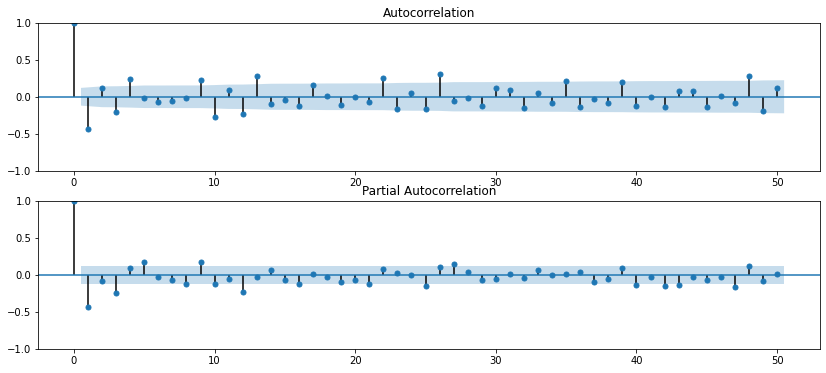

Results of Dickey-Fuller Test for :  HOBBIES
Test Statistic                -1.424993e+01
p-value                        1.487108e-26
#Lags Used                     2.000000e+00
Number of Observations Used    2.650000e+02
Critical Value (1%)           -3.460000e+00
Critical Value (5%)           -2.870000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64
++++++++++++++++++++++++++++++++++++++




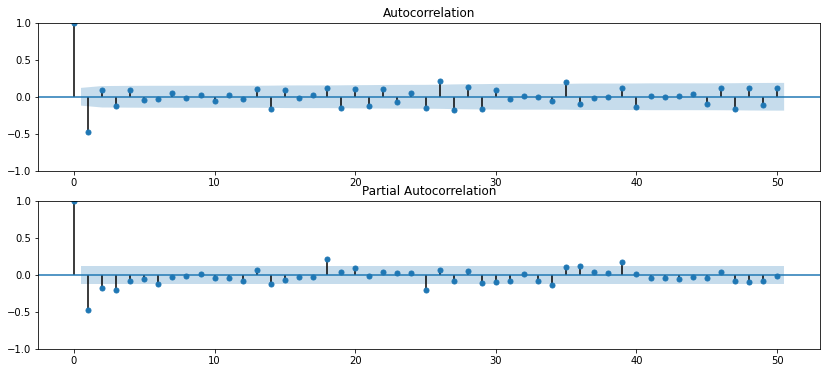

In [ ]:
lists = [sales_cat_weekly_food_diff,sales_cat_weekly_house_diff,sales_cat_weekly_hobbies_diff]

for i in lists:

  print('Results of Dickey-Fuller Test for : ',i.name)
  dftest = adfuller(i)

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = round(value,2)

  print(dfoutput)
  print('++++++++++++++++++++++++++++++++++++++')
  print('\n')

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
  ax1 = plot_acf(i, lags=50, ax=ax1)
  ax2 = plot_pacf(i, lags=50, ax=ax2)
  plt.show()

## Train ARIMA

In [ ]:
# Perform Train Test Splits
train = sales_cat_weekly[:int(0.98*(len(sales_cat_weekly)))]
test = sales_cat_weekly[int(0.98*(len(sales_cat_weekly))):]

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q) using Sliding Window Approach
def evaluate_arima_model(train_set, test_set, arima_order,category='FOODS',logTransformation=False):
  """
  Helper function to evaluate ARIMA Model

  Input: 
    train_set: Train dataframe
    test_set: Test dataframe
    arima_order: order in format (p,d,q)
    category: available choices are FOODS, HOBBIES, HOUSEHOLD

  Output: RMSE score and model fit object for diagnostics
  """

  
  train = train_set[category]

  if logTransformation: # Applying Log transformation for multipicative series
    train = np.log(train)

  test = test_set[category]
  history = [x for x in train]
  
  # make predictions with Walk Forward Evaluation
  predictions = list() 
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    if logTransformation:
      history.append(np.log(test[t]))
    else:
      history.append(test[t])
  # calculate out of sample error

  if logTransformation:
    predictions = np.exp(predictions) # transform forecast back to non-log scale

  error = sqrt(mean_squared_error(test, predictions))
  return error, model_fit

In [ ]:
def modelSummary(originalDF, test_set, category, results, model="arima",logTransformation=False, showConf=True):
  
  """
  Helper Function to show model performance

  Input:
    originalDF: Complete resampled dataframe(daily/weekly/monthly)
    test_set: Test Dataframe containing actual values
    category: available choices are FOODS, HOBBIES, HOUSEHOLD
    results: Model fit argument from evaluation phase

  Output: Shows complete summary along with evaluation plots

  """
  # Result Summary
  print(results.summary())

  # Show complete Diagnostic
  results.plot_diagnostics(figsize=(16, 8))
  plt.savefig('modeldiagnostics')
  plt.show()

  # Get Forecasts
  if model == "arima":
    forecast_object = results.get_forecast(steps=len(test_set))
  elif model == "sarimax":
    forecast_object = results.get_forecast(steps=len(test_set), exog=test_set[exog_list])
  mean = forecast_object.predicted_mean
  conf_int = pd.DataFrame(forecast_object.conf_int())

  if logTransformation: # Transform back to non-log scale
    mean = np.exp(mean)
    conf_int = np.exp(conf_int)
  
  # Plot graph for model evaluation
  plt.figure(figsize=(16,8))

  # Plot original series
  plt.plot(originalDF.index, originalDF[category], label='real')

  # Plot the prediction means as line
  plt.plot(test_set.index, mean, label='predicted')

  # Shade between the confidence intervals
  if showConf:
    plt.fill_between(test_set.index, conf_int.iloc[:,0], conf_int.iloc[:,1],alpha=0.2)

  # Plot legend and show figure
  plt.legend()
  plt.title("Result for "+category+" : "+model+" model")
  plt.xlabel("Timestamp")
  plt.ylabel("Aggregated Sales")
  plt.savefig('predtest_'+category)
  plt.show()

In [ ]:
# Training for ARIMA model using pmdarima library
def trainAutoARIMA(train_set, category, logTransformation=False, param_p=0, param_d=2, param_q=0):
  """
  Helper function to train Auto Arima

  Input: 
    train_set: Train Dataframe
    category: available choices are FOODS, HOBBIES, HOUSEHOLD
    param_p: p for order (p,d,q)
    param_d: d for order (p,d,q)
    param_q: q for order (p,d,q)

  Output: Returns Best Model based on best AIC scores

  """
  if logTransformation: # Apply log transformation for additive series
    train_set[category] = np.log(train_set[category])

  model_a = pm.auto_arima(train_set[category], d=param_d,
                        seasonal=False, trend='c', 
                        start_p=param_p, start_q=param_q, max_order=6, test='adf', 
                        stepwise=True, trace=True)
  return model_a

In [ ]:
# Training for ARIMA using GridSearch based approach(performs slower than Auto ARIMA but capable of better results)
def trainARIMAGridSearch(train_set, test_set, category, p_values, d_values, q_values, logTransformation=False):
  """
  Helper function to train ARIMA using Grid Search

  Input:
    train_set: Train dataframe
    test_set: Test Dataframe
    category: available choices are FOODS, HOBBIES, HOUSEHOLD
    p_values: a list
    d_values: a list
    q_values: a list

  Output:
    Returns the model with best RMSE score

  """
  best_score, best_cfg = float("inf"), None # Initialization
  best_model = None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          [rmse,model_fit] = evaluate_arima_model(train_set, test_set, order,category,logTransformation)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
            best_model = model_fit
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
  return(best_model)

### FOODS

In [ ]:
sales_cat_weekly.FOODS.describe()

count       269.000000
mean     166428.460967
std       22526.638756
min      100337.000000
25%      153994.000000
50%      170327.000000
75%      180856.000000
max      225812.000000
Name: FOODS, dtype: float64

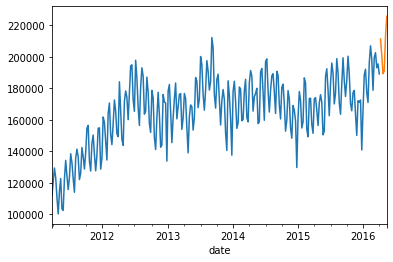

In [ ]:
#sales_cat_weekly.FOODS.plot()
train.FOODS.plot()
test.FOODS.plot()


In [ ]:
transformLog_flag = False

In [ ]:
# Train using Auto Arima
model_food = trainAutoARIMA(train.copy(),'FOODS', logTransformation = transformLog_flag)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5985.937, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5981.485, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5985.937, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5900.881, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5674.390, Time=0.21 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=5647.003, Time=0.30 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5650.335, Time=0.34 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=5611.864, Time=0.43 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=5631.050, Time=0.69 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5679.543, Time=0.66 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=5646.221, Time=1.13 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=5611.8

In [ ]:
[rmse_foods, results_foods] = evaluate_arima_model(train.copy(), test.copy(), model_food.get_params()['order'], 
                                                   'FOODS',logTransformation = transformLog_flag)
print(rmse_foods)

9802.528686386711


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  268
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -2853.150
Date:                Tue, 02 Nov 2021   AIC                           5716.299
Time:                        18:05:12   BIC                           5734.217
Sample:                             0   HQIC                          5723.497
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3093      0.023    -13.510      0.000      -0.354      -0.264
ar.L2         -0.6337      0.030    -21.087      0.000      -0.693      -0.575
ar.L3         -0.5186      0.042    -12.476      0.0

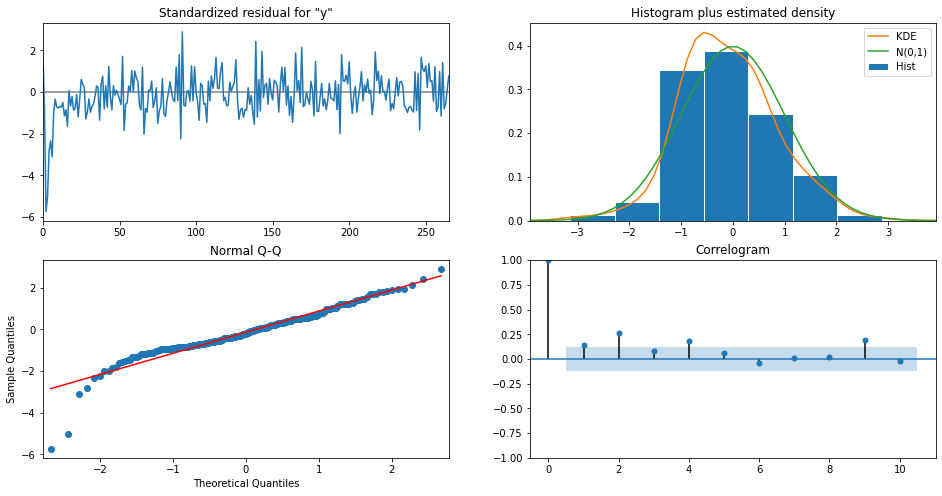

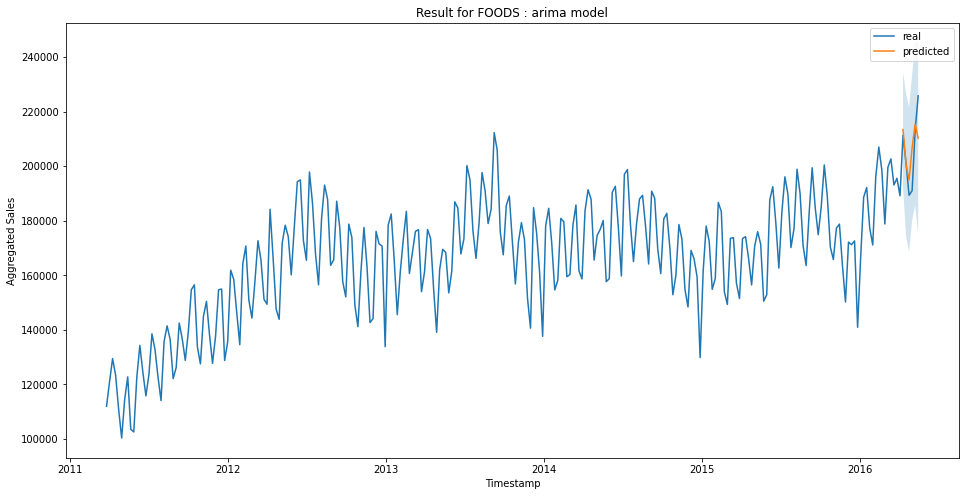

In [ ]:
modelSummary(sales_cat_weekly, test, 'FOODS', results_foods, logTransformation = transformLog_flag)

In [ ]:
# Train using gridsearch

# parameters
p_values = range(0,7)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

results_foods_gs = trainARIMAGridSearch(train.copy(), test.copy(), 'FOODS',p_values,d_values,q_values, logTransformation = transformLog_flag)

ARIMA(0, 0, 0) RMSE=41434.930
ARIMA(0, 0, 1) RMSE=27616.879
ARIMA(0, 0, 2) RMSE=21664.494
ARIMA(0, 0, 3) RMSE=21092.094
ARIMA(0, 1, 0) RMSE=15223.920
ARIMA(0, 1, 2) RMSE=14697.310
ARIMA(0, 2, 3) RMSE=13722.273
ARIMA(0, 3, 3) RMSE=11849.415
ARIMA(2, 1, 2) RMSE=6304.814
ARIMA(4, 2, 3) RMSE=6217.832
Best ARIMA(4, 2, 3) RMSE=6217.832


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  268
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -2838.849
Date:                Mon, 01 Nov 2021   AIC                           5693.697
Time:                        01:41:01   BIC                           5722.365
Sample:                             0   HQIC                          5705.214
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0842      0.036      2.353      0.019       0.014       0.154
ar.L2         -0.9185      0.045    -20.442      0.000      -1.007      -0.830
ar.L3         -0.1689      0.034     -4.976      0.0

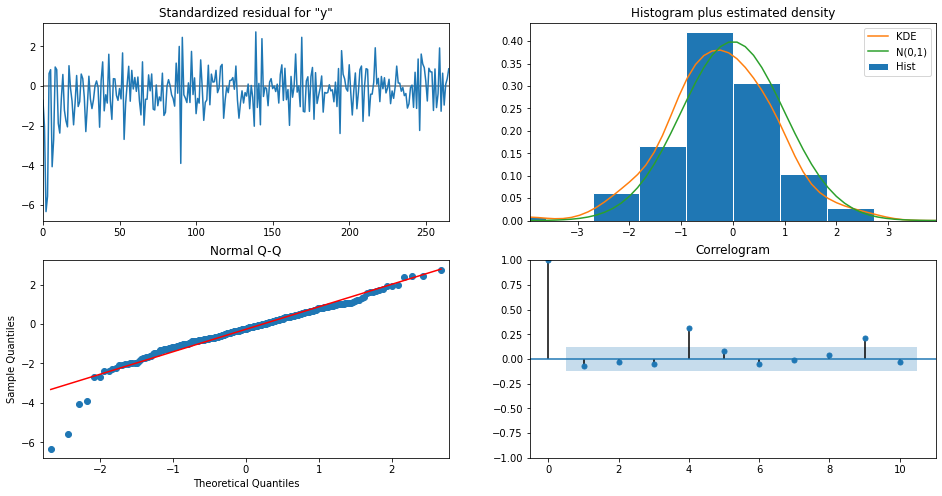

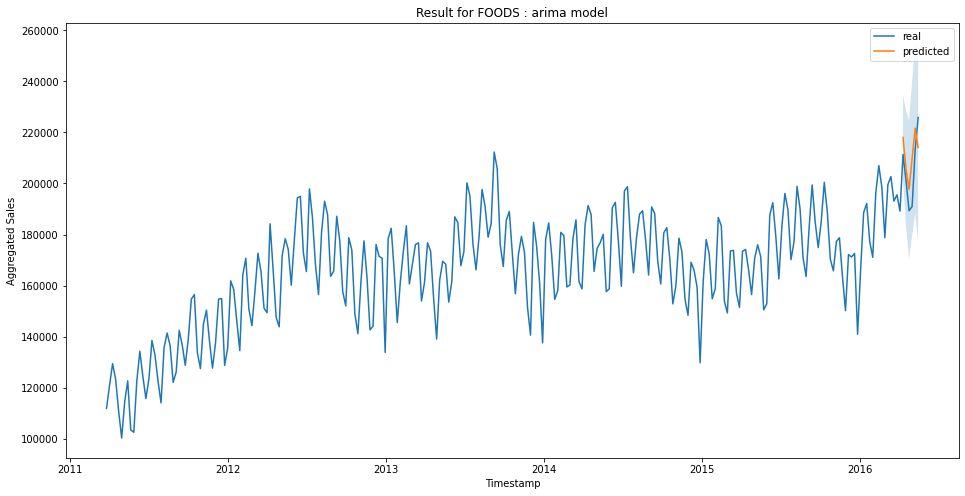

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'FOODS', results_foods_gs, logTransformation = transformLog_flag)

### HOBBIES

In [ ]:
sales_cat_weekly.HOBBIES.describe()

count      269.000000
mean     22569.717472
std       3585.786673
min      13504.000000
25%      19761.000000
50%      22647.000000
75%      25464.000000
max      30690.000000
Name: HOBBIES, dtype: float64

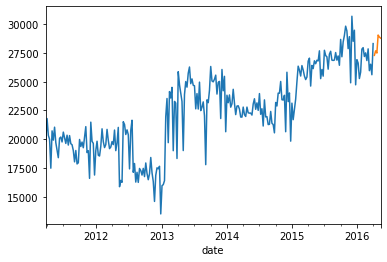

In [ ]:
train.HOBBIES.plot()
test.HOBBIES.plot()

In [ ]:
transformLog_flag = True

In [ ]:
model_hobbies = trainAutoARIMA(train.copy(), 'HOBBIES', logTransformation = transformLog_flag)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-242.303, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-398.826, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-242.303, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-446.904, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-483.926, Time=0.43 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-506.610, Time=0.37 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-515.951, Time=0.51 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-571.943, Time=1.22 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-578.283, Time=1.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-572.745, Time=1.11 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-578.283, T

In [ ]:
[rmse_hobbies, results_hobbies] = evaluate_arima_model(train.copy(), test.copy(), model_hobbies.get_params()['order'], 
                                                       'HOBBIES', logTransformation = transformLog_flag)
print(rmse_hobbies)

712.3897347204284


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  268
Model:                 ARIMA(4, 2, 1)   Log Likelihood                 307.221
Date:                Tue, 02 Nov 2021   AIC                           -602.442
Time:                        18:06:00   BIC                           -580.941
Sample:                             0   HQIC                          -593.804
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5879      0.042    -14.139      0.000      -0.669      -0.506
ar.L2         -0.3110      0.069     -4.537      0.000      -0.445      -0.177
ar.L3         -0.2470      0.048     -5.101      0.0

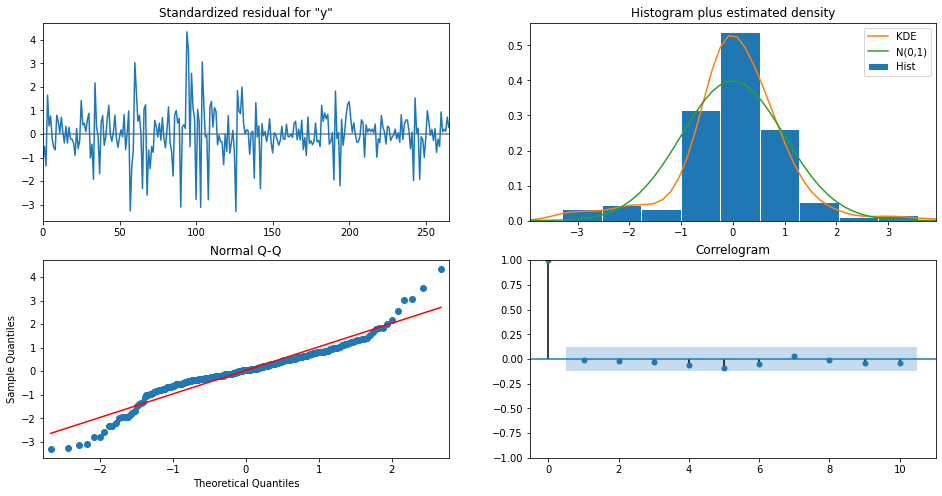

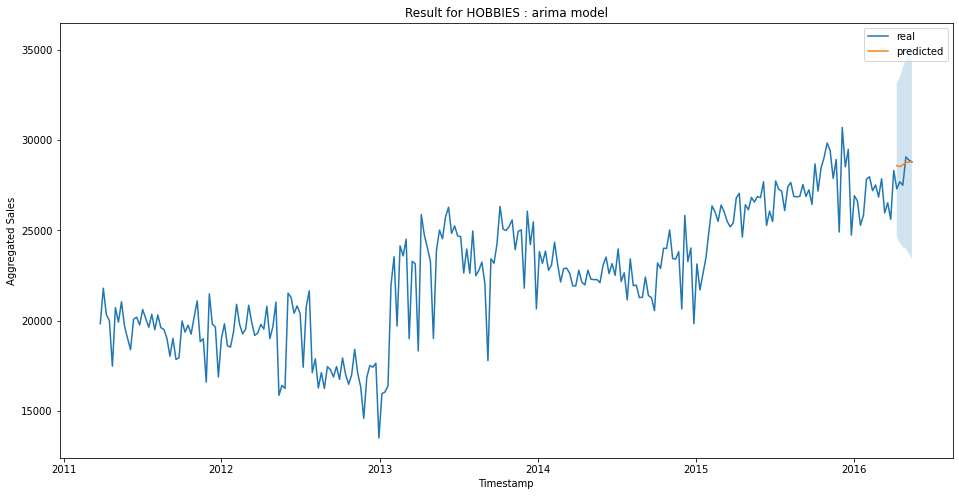

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOBBIES', results_hobbies, logTransformation = transformLog_flag)

In [ ]:
# Train using gridsearch

# parameters
p_values = range(0,7)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

results_hobbies_gs = trainARIMAGridSearch(train.copy(), test.copy(), 'HOBBIES',p_values,d_values,q_values, logTransformation = transformLog_flag)

Log Transformation enabled for  HOBBIES
ARIMA(0, 0, 0) RMSE=6033.481
Log Transformation enabled for  HOBBIES
ARIMA(0, 0, 1) RMSE=4031.374
Log Transformation enabled for  HOBBIES
ARIMA(0, 0, 2) RMSE=2923.697
Log Transformation enabled for  HOBBIES
ARIMA(0, 0, 3) RMSE=2539.599
Log Transformation enabled for  HOBBIES
ARIMA(0, 1, 0) RMSE=787.972
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
ARIMA(0, 2, 1) RMSE=786.991
Log Transformation enabled for  HOBBIES
ARIMA(0, 2, 2) RMSE=769.395
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
ARIMA(0, 3, 3) RMSE=701.475
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transformation enabled for  HOBBIES
Log Transfor

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  268
Model:                 ARIMA(4, 2, 0)   Log Likelihood                 266.714
Date:                Mon, 01 Nov 2021   AIC                           -523.429
Time:                        01:47:18   BIC                           -505.511
Sample:                             0   HQIC                          -516.231
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2302      0.047    -25.962      0.000      -1.323      -1.137
ar.L2         -1.0143      0.072    -14.021      0.000      -1.156      -0.873
ar.L3         -0.7117      0.071    -10.061      0.0

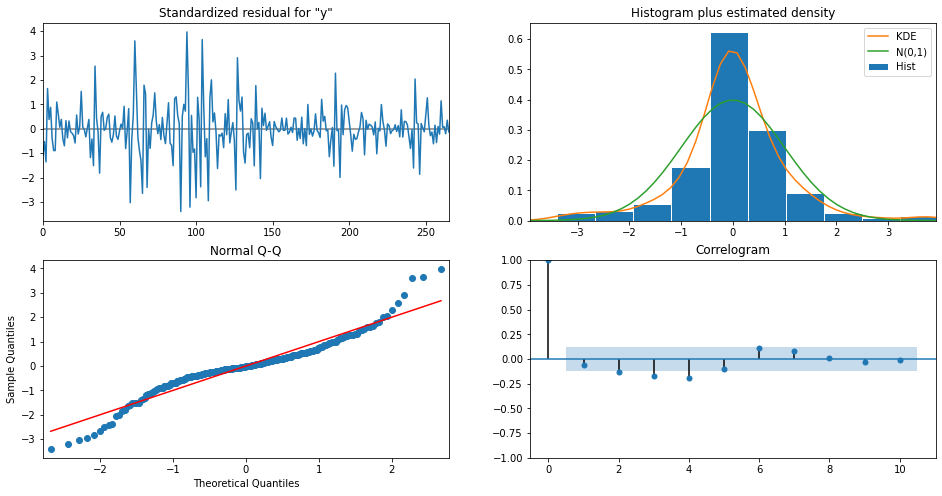

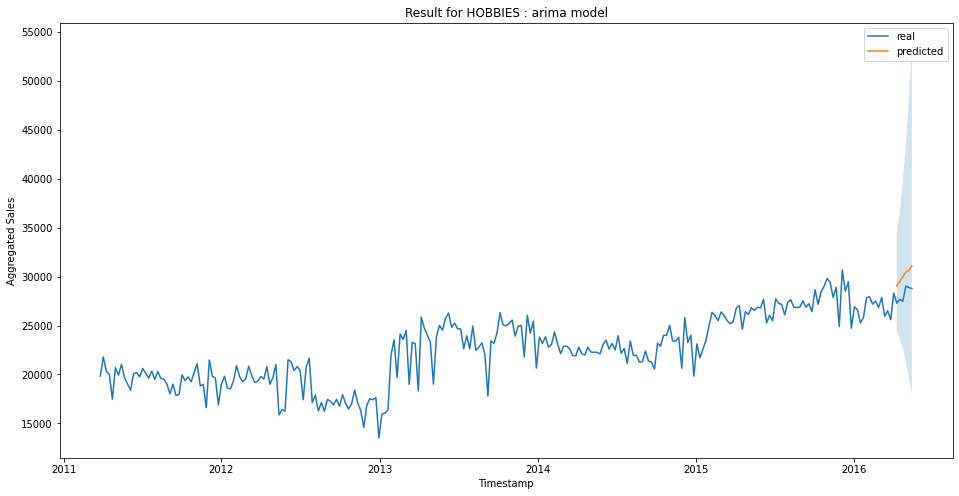

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOBBIES', results_hobbies_gs, logTransformation = transformLog_flag)

### HOUSEHOLDS

In [ ]:
sales_cat_weekly.HOUSEHOLD.describe()

count      269.000000
mean     53721.802974
std      11577.713712
min      27146.000000
25%      46174.000000
50%      55698.000000
75%      61994.000000
max      75163.000000
Name: HOUSEHOLD, dtype: float64

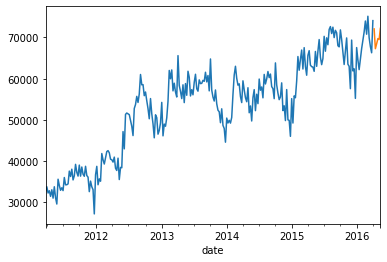

In [ ]:
train.HOUSEHOLD.plot()
test.HOUSEHOLD.plot()

In [ ]:
transformLog_flag = True

In [ ]:
model_household = trainAutoARIMA(train.copy(), 'HOUSEHOLD', logTransformation = transformLog_flag)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-360.974, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-528.243, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-360.974, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-559.300, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-622.363, Time=0.31 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-665.353, Time=0.48 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-667.290, Time=0.62 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-680.818, Time=1.31 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-679.100, Time=1.04 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=-692.759, Time=1.38 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-686.323, Time=1.23 sec
 ARIMA(5,2,3)(0,0,0)[0] intercept   : AIC=-652.866, Time=1.60 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=-688.583, Time=1.21 sec
 ARIMA(5,2,2)(0,0,0)[0]             : 

In [ ]:
[rmse_household, results_household] = evaluate_arima_model(train.copy(), test.copy(), model_household.get_params()['order'], 
                                                           'HOUSEHOLD', logTransformation = transformLog_flag)
print(rmse_household)

2532.6308809215525


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  268
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 366.921
Date:                Tue, 02 Nov 2021   AIC                           -717.842
Time:                        18:06:49   BIC                           -689.174
Sample:                             0   HQIC                          -706.325
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2730      0.121    -10.555      0.000      -1.509      -1.037
ar.L2         -0.5406      0.105     -5.137      0.000      -0.747      -0.334
ar.L3         -0.2974      0.105     -2.843      0.0

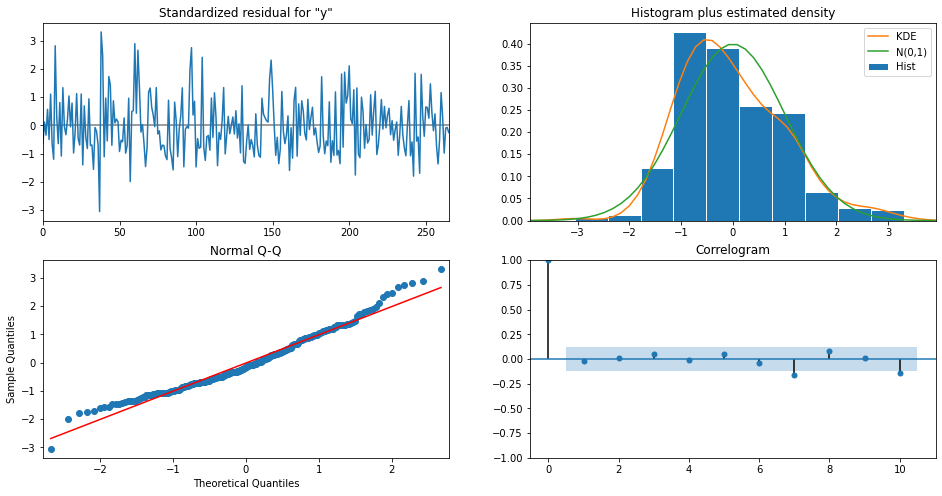

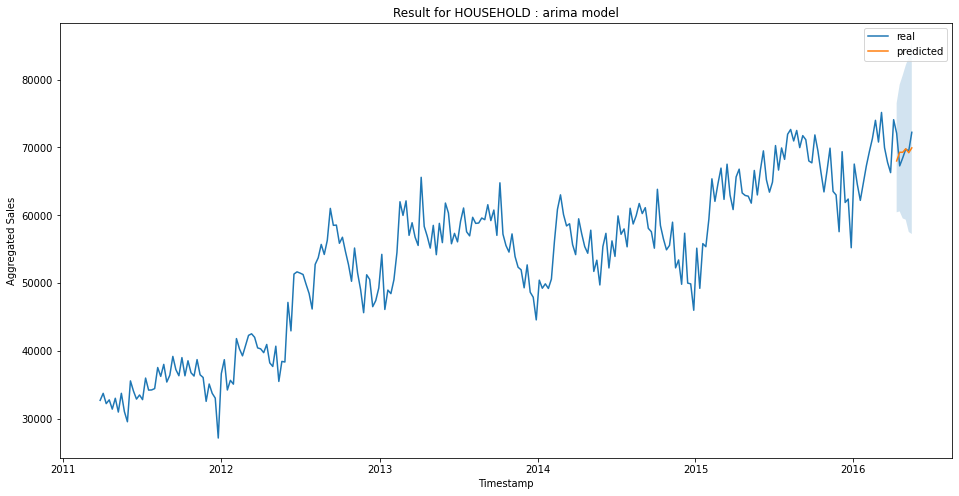

In [ ]:
modelSummary(sales_cat_weekly, test, 'HOUSEHOLD', results_household, logTransformation = transformLog_flag)

In [ ]:
# Train using gridsearch

# parameters
p_values = range(0,7)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

results_household_gs = trainARIMAGridSearch(train.copy(), test.copy(), 'HOUSEHOLD',p_values,d_values,q_values, logTransformation = transformLog_flag)

ARIMA(0, 0, 0) RMSE=17824.416
ARIMA(0, 0, 1) RMSE=10723.707
ARIMA(0, 0, 2) RMSE=7846.898
ARIMA(0, 0, 3) RMSE=6493.357
ARIMA(0, 1, 0) RMSE=2505.612
ARIMA(0, 1, 1) RMSE=2210.714
ARIMA(5, 1, 3) RMSE=2139.595
ARIMA(6, 2, 1) RMSE=2130.081
Best ARIMA(6, 2, 1) RMSE=2130.081


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  268
Model:                 ARIMA(6, 2, 1)   Log Likelihood                 363.453
Date:                Mon, 01 Nov 2021   AIC                           -710.907
Time:                        01:43:46   BIC                           -682.239
Sample:                             0   HQIC                          -699.390
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4857      0.047    -10.339      0.000      -0.578      -0.394
ar.L2         -0.2004      0.060     -3.333      0.001      -0.318      -0.083
ar.L3         -0.2207      0.066     -3.334      0.0

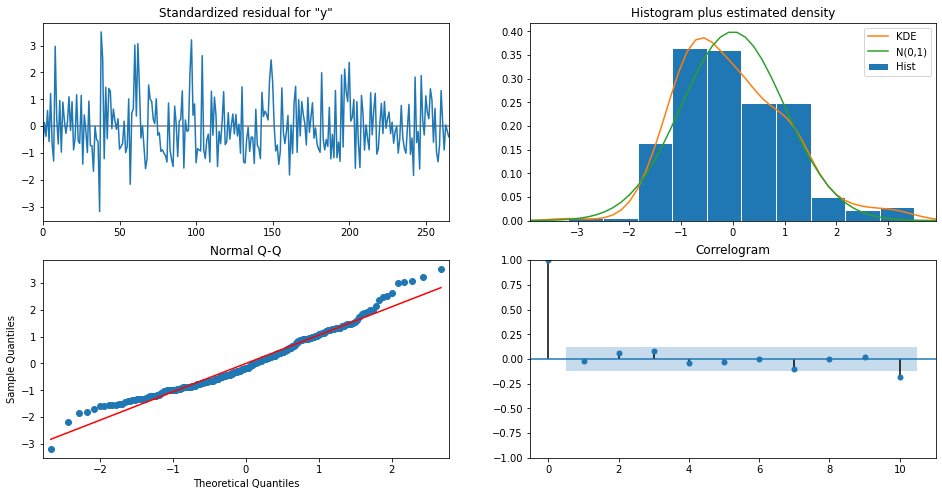

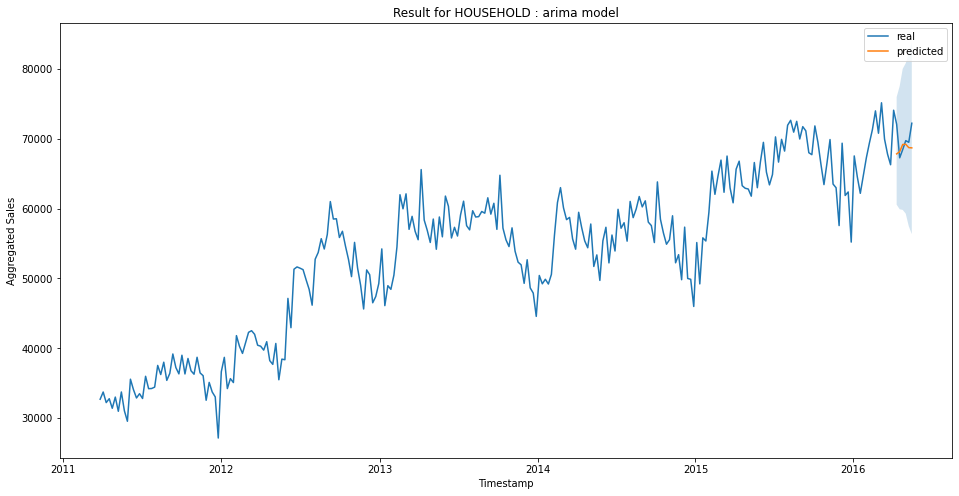

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOUSEHOLD', results_household_gs, logTransformation = transformLog_flag)

## SARIMAX Training

In [ ]:
def trainSeasonalAutoARIMA(train_set, category, tr='t', param_p=5, param_d=2, param_q=3, param_D=1,logTransformation = False):
  """
  Helper function to train Seasonal Auto Arima

  Input: 
    train_set: Train Dataframe
    category: available choices are FOODS, HOBBIES, HOUSEHOLD
    tr: parameter to specify trend ('c', 't', 'ct')
    param_p: p for order (p,d,q)
    param_d: d for order (p,d,q)
    param_q: q for order (p,d,q)
    param_D: D for order (P,D,Q,m)

  Output: Returns Best Model based on best AIC scores

  """
  if logTransformation:
    train_set[category] = np.log(train_set[category])

  model_b = pm.auto_arima(y=train_set[category], X= train_set[exog_list], d=param_d, D=param_D,
                      seasonal=True, m=12, trend=tr, start_p=0, start_q=0,
                      max_p=param_p, max_q=param_q, max_order=8, test='adf', stepwise=True, 
                      trace=True, n_jobs=-1 )
  return model_b

In [ ]:
# Training for ARIMA using GridSearch based approach(performs slower than Auto ARIMA but capable of better results)
def trainSeasonalARIMAGridSearch(train_set, test_set, category, p_values, d_values, q_values, t_params, 
                                 P_values, D_values, Q_values, logTransformation = False):
  """
  Helper function to train ARIMA using Grid Search

  Input:
    train_set: Train dataframe
    test_set: Test Dataframe
    category: available choices are FOODS, HOBBIES, HOUSEHOLD
    p_values: a list
    d_values: a list
    q_values: a list

  Output:
    Returns the model with best RMSE score

  """
  best_score, best_cfg = float("inf"), None 
  best_model = None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        for t in t_params:
          for P in P_values:
            for D in D_values:
              for Q in Q_values:
                order = [(p,d,q), (P,D,Q,12), t]
                try:
                  #print('Fitting for ',order)
                  [rmse,model_fit] = evaluate_seasonal_arima_model(train_set.copy(), test_set.copy(), order,category, logTransformation)
                  if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('SARIMAX%s RMSE=%.3f' % (order,rmse))
                    best_model = model_fit
                except:
                  continue
  print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_score))
  return(best_model)

In [ ]:
# evaluate an Seasonal ARIMA model with Walk Forward Evaluation
def evaluate_seasonal_arima_model(train_set, test_set, config_params,category='FOODS', logTransformation = False):
  """
  Helper function to evaluate Seasonal ARIMA Model

  Input: 
    train_set: Train dataframe
    test_set: Test dataframe
    arima_order: order in format (p,d,q)
    category: available choices are FOODS, HOBBIES, HOUSEHOLD

  Output: RMSE score and model fit object for diagnostics
  """
  
  test = test_set[category]
  order, sorder, trend = config_params
  
  if logTransformation:
    #print("Log transformation enabled with config ", config_params)
    train_set[category] = np.log(train_set[category])

  model = SARIMAX(endog=train_set[category],exog=train[exog_list],order=order,
                  seasonal_order=sorder, trend=trend)
  model_fit = model.fit()

  forecast_object = model_fit.get_forecast(steps=len(test_set), 
                                           exog=test_set[exog_list])
  mean = forecast_object.predicted_mean

  if logTransformation:
    mean = np.exp(mean)

  error = sqrt(mean_squared_error(test, mean))

  # # make predictions with Walk Forward Evaluation
  # predictions = list() 
  # for t in range(len(test)):
  #   model = SARIMAX(endog=train_set[category], exog=train_set[exog_list], order=order, seasonal_order=sorder, trend=trend)
  #   model_fit = model.fit()
  #   yhat = model_fit.predict(len(train_set), len(train_set),exog=test_set[exog_list].iloc[[t]])[0]
  #   predictions.append(yhat)
  #   train_set = train_set.append(test_set.iloc[[t]])
  # # calculate out of sample error
  # error = sqrt(mean_squared_error(test, predictions))

  return error, model_fit

In [ ]:
train = sales_cat_weekly[:int(0.98*(len(sales_cat_weekly)))]
test = sales_cat_weekly[int(0.98*(len(sales_cat_weekly))):] # 6 weeks, To keep close to 28 days

### FOODS

In [ ]:
transformLog_flag = False

In [ ]:
sarima_model_foods = trainSeasonalAutoARIMA(train.copy(),'FOODS', logTransformation = transformLog_flag)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=5889.353, Time=0.12 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=5871.723, Time=1.06 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=6.08 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=5879.619, Time=0.22 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=5776.957, Time=2.99 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=5731.751, Time=7.01 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(1,2,0)(2,1,2)[12]             : AIC=5726.369, Time=8.22 sec
 ARIMA(1,2,0)(1,1,2)[12]             : AIC=inf, Time=6.43 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AIC=5758.617, Time=6.53 sec
 ARIMA(2,2,0)(2,1,2)[12]             : AIC=5675.986, Time=8.14 sec
 ARIMA(2,2,0)(1,1,2)[12]             : AIC=inf, Time=8.09 sec
 ARIMA(2,2,0)(2,1,1)[12]             : AIC=5683.156, Time=6.56 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=5

In [ ]:
# Extract Model Parameters
order = sarima_model_foods.get_params()['order']
seasonal_order = sarima_model_foods.get_params()['seasonal_order']
trend = sarima_model_foods.get_params()['trend']

model_params = [order, seasonal_order, trend]
model_params

In [ ]:
model_params = [(4, 2, 3), (0, 1, 1, 12), 't']

In [ ]:
[rmse_sarima_foods, smodel_foods] = evaluate_seasonal_arima_model(train.copy(), test.copy(), model_params,
                                                                  'FOODS', logTransformation = transformLog_flag)
print(rmse_sarima_foods)

4802.5490228635


                                      SARIMAX Results                                       
Dep. Variable:                                FOODS   No. Observations:                  263
Model:             SARIMAX(4, 2, 3)x(0, 1, [1], 12)   Log Likelihood               -2645.752
Date:                              Mon, 01 Nov 2021   AIC                           5327.503
Time:                                      01:50:04   BIC                           5390.817
Sample:                                  03-27-2011   HQIC                          5352.988
                                       - 04-03-2016                                         
Covariance Type:                                opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
drift                      0.0839      0.107      0.785      0.433      -0

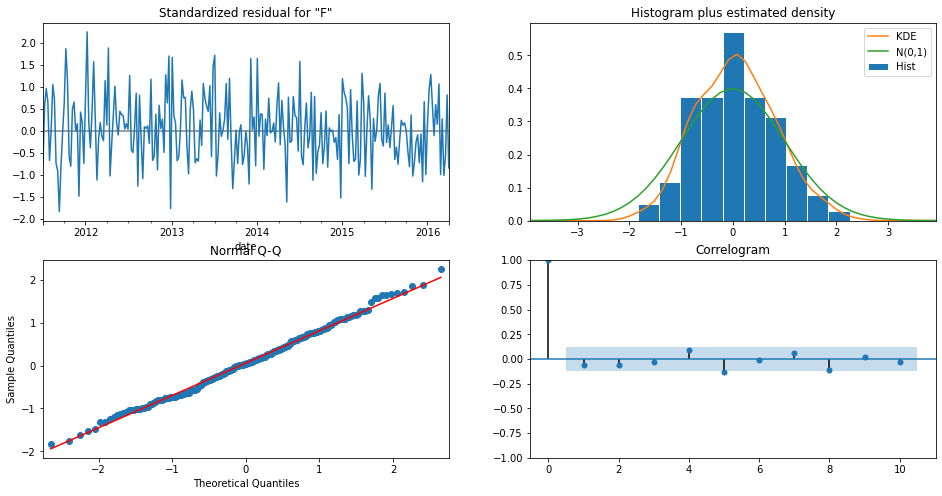

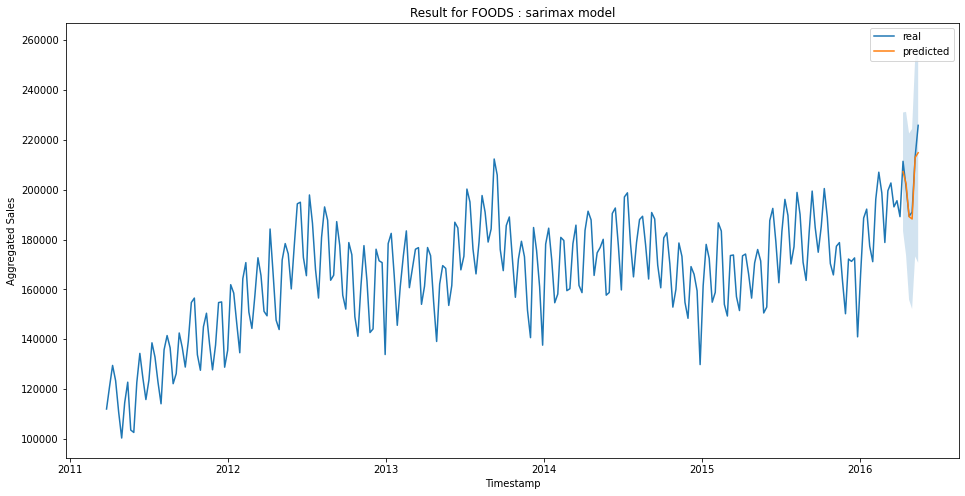

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'FOODS', smodel_foods, model="sarimax", logTransformation = transformLog_flag)

### HOBBIES

In [ ]:
transformLog_flag = True

In [ ]:
sarima_model_hobbies = trainSeasonalAutoARIMA(train.copy(),'HOBBIES',tr='c', logTransformation = transformLog_flag, param_D=1, param_d=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=5.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-320.881, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-435.732, Time=5.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-392.715, Time=0.88 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-469.641, Time=10.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-410.179, Time=6.64 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-479.069, Time=12.85 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-447.401, Time=6.10 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=-530.524, Time=15.01 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=7.28 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=15.80 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=i

In [ ]:
# Extract Model Parameters
order = sarima_model_hobbies.get_params()['order']
seasonal_order = sarima_model_hobbies.get_params()['seasonal_order']
trend = sarima_model_hobbies.get_params()['trend']

model_params = [order, seasonal_order, trend]
model_params

[(3, 1, 0), (2, 1, 1, 12), 'c']

In [ ]:
[rmse_sarima_hobbies, smodel_hobbies] = evaluate_seasonal_arima_model(train.copy(), test.copy(), model_params,
                                                                      'HOBBIES', logTransformation = transformLog_flag)
print(rmse_sarima_hobbies)

873.4392835152723


                                      SARIMAX Results                                       
Dep. Variable:                              HOBBIES   No. Observations:                  263
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 284.641
Date:                              Sat, 30 Oct 2021   AIC                           -537.282
Time:                                      18:35:14   BIC                           -480.938
Sample:                                  03-27-2011   HQIC                          -514.605
                                       - 04-03-2016                                         
Covariance Type:                                opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0.0003      0.001      0.249      0.804      -0

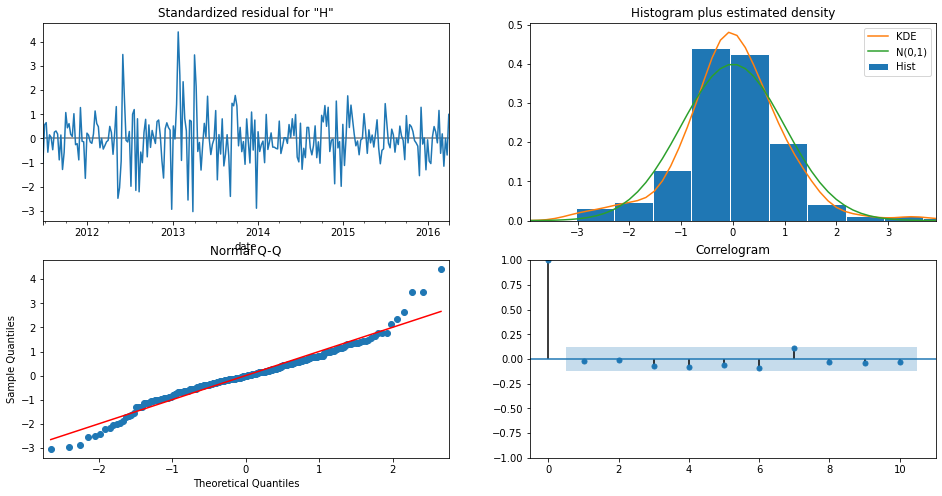

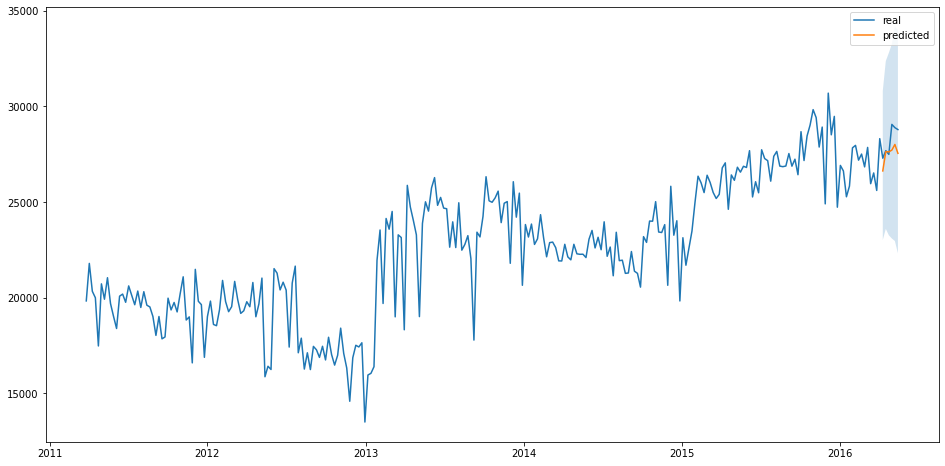

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOBBIES', smodel_hobbies, model="sarimax", logTransformation = transformLog_flag)

In [ ]:
# define config lists
p_params = [0, 1, 2, 3, 4]
d_params = [0, 1, 2]
q_params = [0, 1, 2]
t_params = ['n','c','t']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]

smodel_hobbies_gs = trainSeasonalARIMAGridSearch(train.copy(), test.copy(), 'HOBBIES', p_params, d_params, q_params, t_params, 
                                                 P_params, D_params, Q_params, logTransformation = transformLog_flag)

Log transformation enabled with config  [(0, 0, 0), (0, 0, 0, 12), 'n']
SARIMAX[(0, 0, 0), (0, 0, 0, 12), 'n'] RMSE=710797.221
Log transformation enabled with config  [(0, 0, 0), (0, 0, 1, 12), 'n']
SARIMAX[(0, 0, 0), (0, 0, 1, 12), 'n'] RMSE=29635.316
Log transformation enabled with config  [(0, 0, 0), (0, 0, 2, 12), 'n']
SARIMAX[(0, 0, 0), (0, 0, 2, 12), 'n'] RMSE=25898.197
Log transformation enabled with config  [(0, 0, 0), (0, 1, 0, 12), 'n']
SARIMAX[(0, 0, 0), (0, 1, 0, 12), 'n'] RMSE=1990.683
Log transformation enabled with config  [(0, 0, 0), (0, 1, 1, 12), 'n']
SARIMAX[(0, 0, 0), (0, 1, 1, 12), 'n'] RMSE=1517.195
Log transformation enabled with config  [(0, 0, 0), (0, 1, 2, 12), 'n']
Log transformation enabled with config  [(0, 0, 0), (1, 0, 0, 12), 'n']
Log transformation enabled with config  [(0, 0, 0), (1, 0, 1, 12), 'n']
Log transformation enabled with config  [(0, 0, 0), (1, 0, 2, 12), 'n']
Log transformation enabled with config  [(0, 0, 0), (1, 1, 0, 12), 'n']
Log transfo

                                      SARIMAX Results                                       
Dep. Variable:                              HOBBIES   No. Observations:                  263
Model:             SARIMAX(3, 2, 0)x(1, 0, [1], 12)   Log Likelihood                 264.943
Date:                              Mon, 01 Nov 2021   AIC                           -499.886
Time:                                      01:52:45   BIC                           -446.418
Sample:                                  03-27-2011   HQIC                          -478.394
                                       - 04-03-2016                                         
Covariance Type:                                opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
drift                  -2.408e-06   5.18e-05     -0.047      0.963      -0

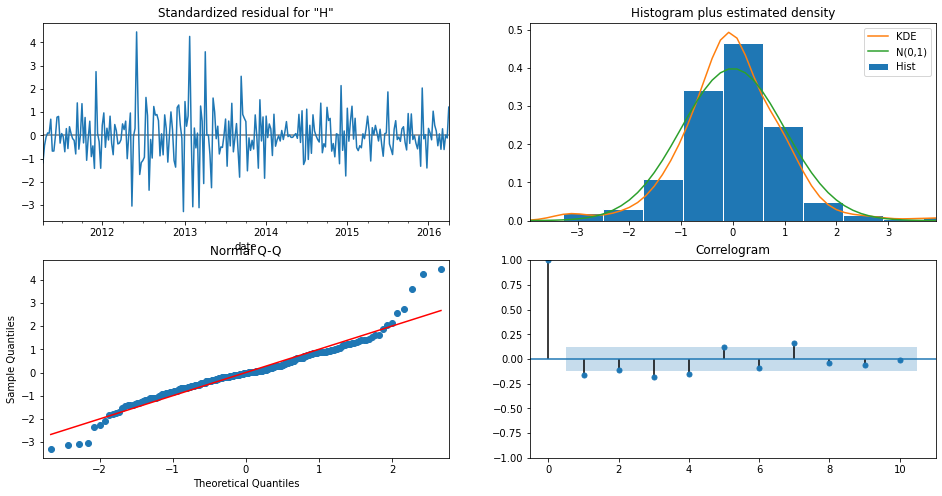

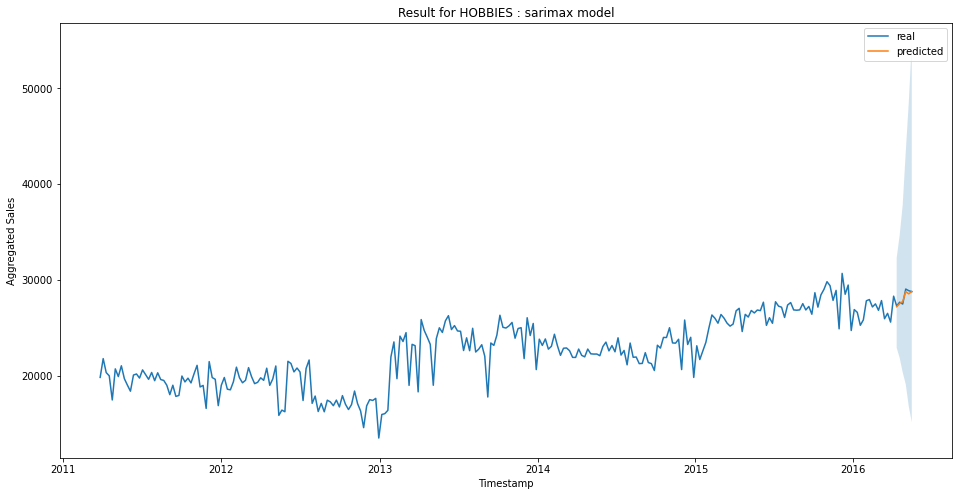

In [ ]:
#[(3, 2, 0), (1, 0, 1, 12), 't'] RMSE=215.284

modelSummary(sales_cat_weekly, test.copy(), 'HOBBIES', smodel_hobbies_gs, model="sarimax", 
             showConf=True, logTransformation = transformLog_flag)

### HOUSEHOLD

In [ ]:
transformLog_flag = True

In [ ]:
sarima_model_household = trainSeasonalAutoARIMA(train.copy(),'HOUSEHOLD',tr='c',logTransformation = transformLog_flag, param_d=1, param_D=0)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-658.855, Time=2.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-631.929, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-692.553, Time=1.89 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-700.906, Time=2.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-631.929, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-689.766, Time=1.26 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-697.543, Time=3.10 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-698.957, Time=5.92 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-699.914, Time=2.27 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-697.602, Time=6.58 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-645.006, Time=1.43 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-699.507, Time=2.73 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-699.539, Time=2.51 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-694.782, Time=2.28 sec
 ARIMA(1,1,2)(0,0,1

In [ ]:
# Extract Model Parameters
order = sarima_model_household.get_params()['order']
seasonal_order = sarima_model_household.get_params()['seasonal_order']
trend = sarima_model_household.get_params()['trend']

model_params = [order, seasonal_order, trend]
model_params

[(0, 1, 1), (0, 0, 1, 12), 'c']

In [ ]:
[rmse_sarima_household, smodel_household] = evaluate_seasonal_arima_model(train.copy(), test.copy(), model_params,
                                                                          'HOUSEHOLD', logTransformation = transformLog_flag)
print(rmse_sarima_household)

2087.4956610776103


                                     SARIMAX Results                                      
Dep. Variable:                          HOUSEHOLD   No. Observations:                  263
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 362.453
Date:                            Sat, 30 Oct 2021   AIC                           -700.906
Time:                                    18:13:59   BIC                           -658.086
Sample:                                03-27-2011   HQIC                          -683.696
                                     - 04-03-2016                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0.0029      0.002      1.759      0.079      -0.000       0.006

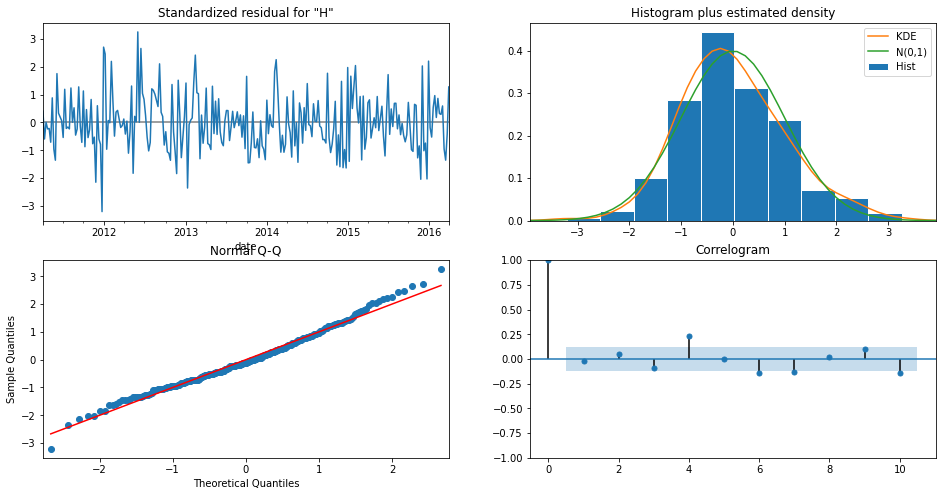

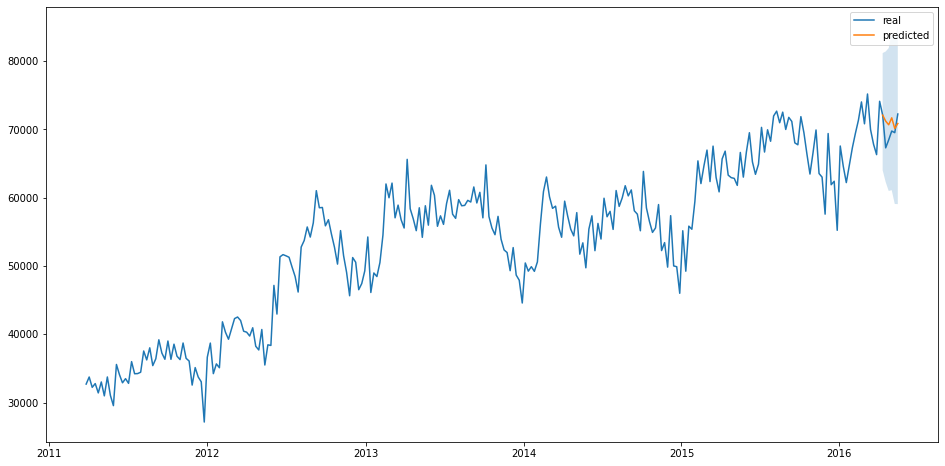

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOUSEHOLD', smodel_household, model="sarimax", logTransformation = transformLog_flag)

In [ ]:
# define config lists
p_params = [0, 1, 2, 3]
d_params = [0, 1, 2]
q_params = [0, 1, 2]
t_params = ['n','c','t']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]

smodel_household_gs = trainSeasonalARIMAGridSearch(train.copy(), test.copy(), 'HOUSEHOLD', p_params, d_params, q_params, t_params, 
                                                   P_params, D_params, Q_params, logTransformation = transformLog_flag)

SARIMAX[(0, 0, 0), (0, 0, 0, 12), 'n'] RMSE=2403188.631
SARIMAX[(0, 0, 0), (0, 0, 1, 12), 'n'] RMSE=87026.581
SARIMAX[(0, 0, 0), (0, 0, 2, 12), 'n'] RMSE=60516.331
SARIMAX[(0, 0, 0), (0, 1, 0, 12), 'n'] RMSE=4205.081
SARIMAX[(0, 0, 0), (0, 1, 1, 12), 'n'] RMSE=3860.776
SARIMAX[(0, 0, 0), (2, 1, 1, 12), 'n'] RMSE=3706.414
SARIMAX[(0, 0, 0), (0, 1, 1, 12), 'c'] RMSE=3279.826
SARIMAX[(0, 0, 0), (0, 1, 2, 12), 'c'] RMSE=3263.577
SARIMAX[(0, 0, 0), (1, 1, 0, 12), 'c'] RMSE=3113.706
SARIMAX[(0, 0, 0), (1, 1, 2, 12), 'c'] RMSE=3028.356
SARIMAX[(0, 0, 0), (2, 1, 2, 12), 'c'] RMSE=2952.140
SARIMAX[(0, 0, 1), (0, 1, 0, 12), 'n'] RMSE=2516.981
SARIMAX[(0, 0, 1), (2, 1, 2, 12), 'c'] RMSE=2180.295
SARIMAX[(0, 1, 1), (0, 0, 0, 12), 'n'] RMSE=1957.349
SARIMAX[(0, 1, 1), (0, 0, 1, 12), 'n'] RMSE=1956.448
SARIMAX[(0, 1, 1), (0, 0, 2, 12), 'n'] RMSE=1936.969
SARIMAX[(0, 1, 2), (0, 0, 2, 12), 'n'] RMSE=1864.541
SARIMAX[(0, 2, 2), (2, 0, 0, 12), 'c'] RMSE=1770.416
SARIMAX[(3, 1, 1), (0, 0, 1, 12), 'c'] RM

                                     SARIMAX Results                                      
Dep. Variable:                          HOUSEHOLD   No. Observations:                  263
Model:             SARIMAX(3, 2, 2)x(0, 0, 2, 12)   Log Likelihood                 347.239
Date:                            Mon, 01 Nov 2021   AIC                           -660.478
Time:                                    01:54:47   BIC                           -599.882
Sample:                                03-27-2011   HQIC                          -636.120
                                     - 04-03-2016                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
drift                  -6.856e-07   1.07e-05     -0.064      0.949   -2.16e-05    2.02e-05

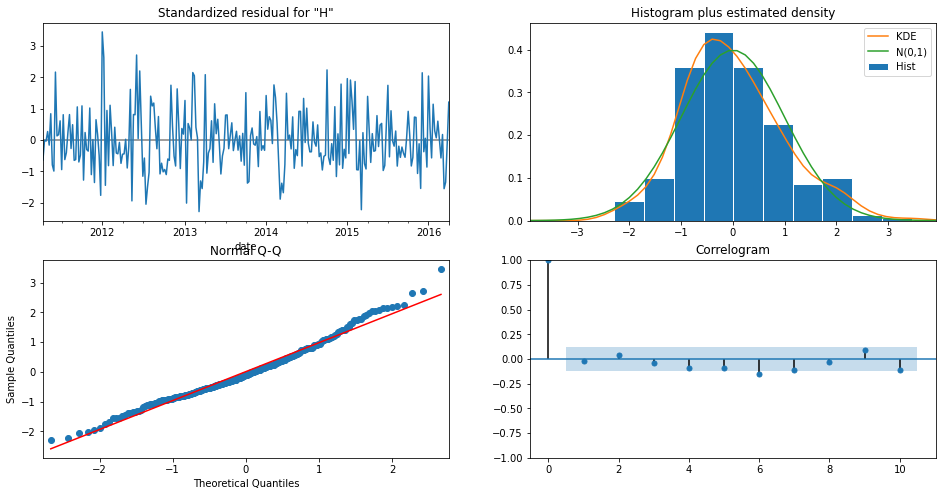

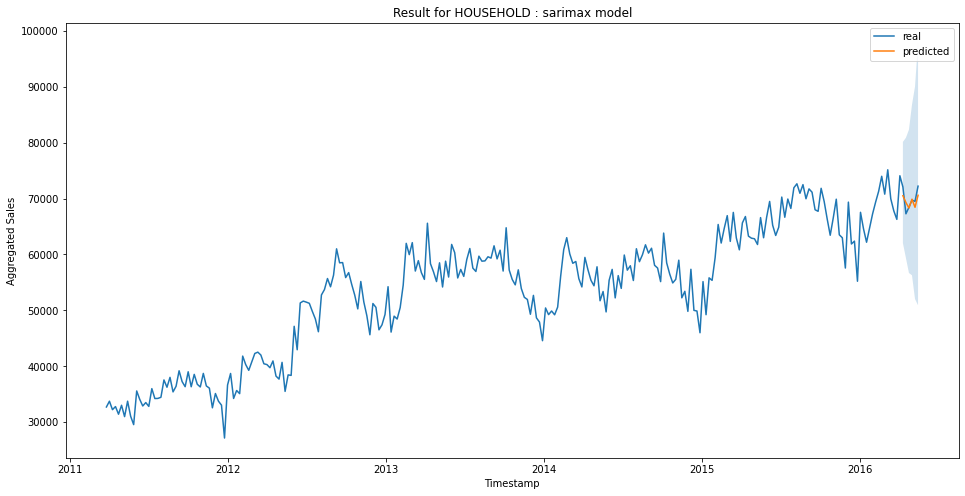

In [ ]:
#[(3, 2, 2), (0, 0, 2, 12), 't'] 1314.606

modelSummary(sales_cat_weekly, test.copy(), 'HOUSEHOLD', smodel_household_gs, model="sarimax", 
             showConf=True, logTransformation = transformLog_flag)

# Phase 2: Resampled Daily 
[Update 10/30: Yet to train the models after code refactoring]

In [ ]:
sales_cat_daily = resampleData(sales_cat.copy(),"D") #daily resampling
sales_cat_daily.head()

,FOODS,HOBBIES,HOUSEHOLD,isWeekend,isWeekday,inbetween25and5,event_on_weekend,event_on_weekday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural
date,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,1,0,1,0,0,0,0,0,0,0
2011-01-30,22758,3357,5634,1,0,1,0,0,0,0,0,0,0
2011-01-31,17174,2682,3927,0,1,1,0,0,0,0,0,0,0
2011-02-01,18878,2669,3865,0,1,1,0,0,0,0,0,0,0
2011-02-02,14603,1814,2729,0,1,1,0,0,0,0,0,0,0


In [ ]:
exog_list = list(sales_cat_daily.columns[3:])
lists = ['FOODS','HOBBIES','HOUSEHOLD']
plotSeries(sales_cat_daily, lists)

Seasonal Decompose on Daily Resampled Data


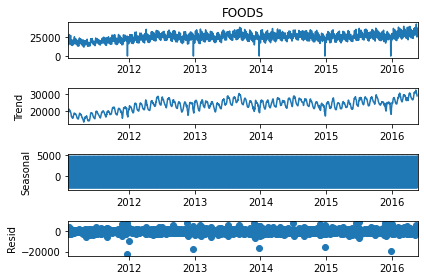

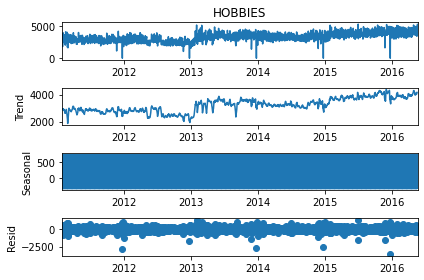

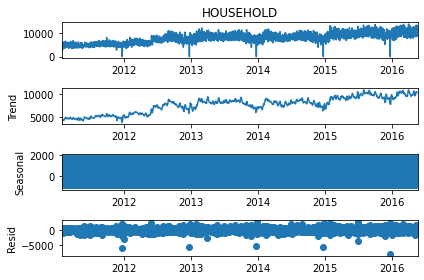

In [ ]:
print('Seasonal Decompose on Daily Resampled Data')
for i in lists:
    sm.tsa.seasonal_decompose(sales_cat_daily[i]).plot()
    #fig.update_layout(title_text=i)

**ADF TEST on daily data**

Results of Dickey-Fuller Test for :  FOODS
Test Statistic                   -1.558381
p-value                           0.504459
#Lags Used                       26.000000
Number of Observations Used    1914.000000
Critical Value (1%)              -3.430000
Critical Value (5%)              -2.860000
Critical Value (10%)             -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




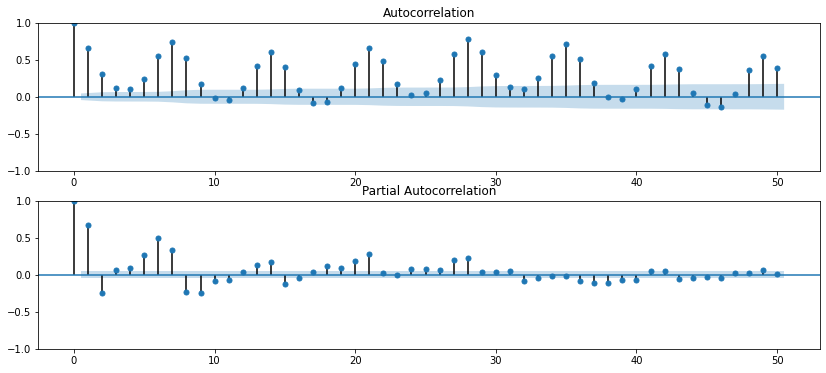

Results of Dickey-Fuller Test for :  HOBBIES
Test Statistic                   -1.685561
p-value                           0.438567
#Lags Used                       26.000000
Number of Observations Used    1914.000000
Critical Value (1%)              -3.430000
Critical Value (5%)              -2.860000
Critical Value (10%)             -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




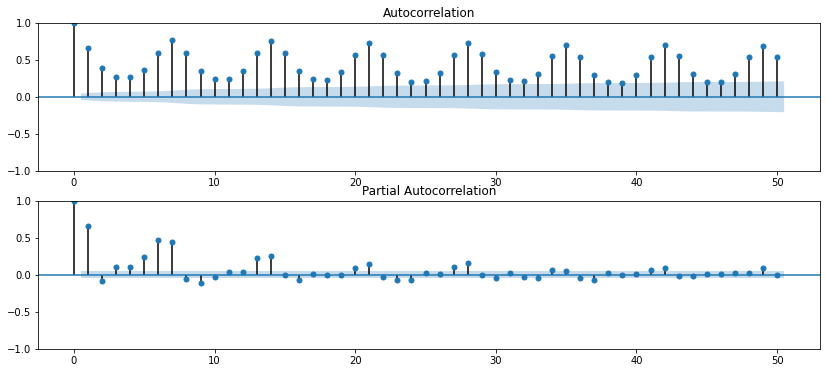

Results of Dickey-Fuller Test for :  HOUSEHOLD
Test Statistic                   -1.486333
p-value                           0.540261
#Lags Used                       26.000000
Number of Observations Used    1914.000000
Critical Value (1%)              -3.430000
Critical Value (5%)              -2.860000
Critical Value (10%)             -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




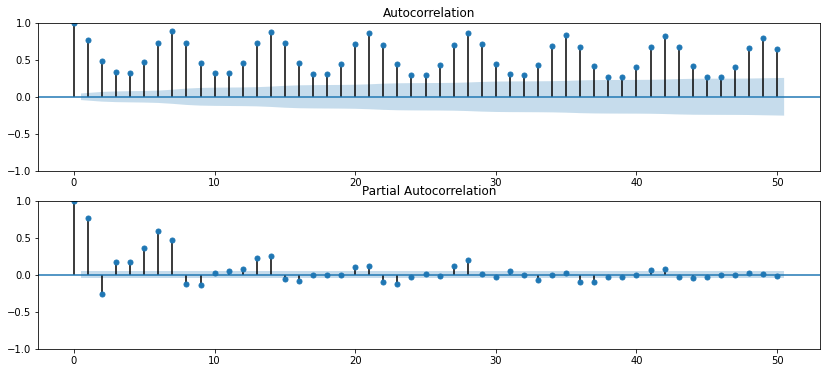

In [ ]:
# Perform ADF Test

performADFTest(sales_cat_daily,lists)

In [ ]:
sales_cat_food = sales_cat_daily['FOODS']
sales_cat_house = sales_cat_daily['HOUSEHOLD']
sales_cat_hobbies = sales_cat_daily['HOBBIES']

In [ ]:
sales_cat_food_diff = sales_cat_food.diff(2)
sales_cat_house_diff = sales_cat_house.diff(1)
sales_cat_hobbies_diff = sales_cat_hobbies.diff(1)
sales_cat_food_diff = sales_cat_food_diff.dropna()
sales_cat_house_diff = sales_cat_house_diff.dropna()
sales_cat_hobbies_diff = sales_cat_hobbies_diff.dropna()

Results of Dickey-Fuller Test for :  FOODS
Test Statistic                  -22.458851
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1912.000000
Critical Value (1%)              -3.430000
Critical Value (5%)              -2.860000
Critical Value (10%)             -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




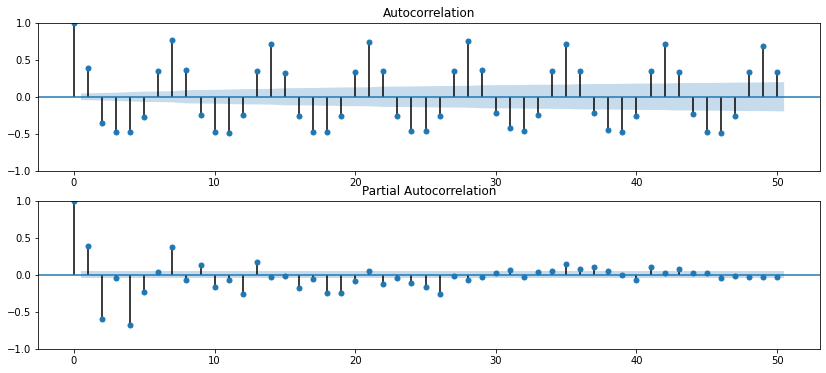

Results of Dickey-Fuller Test for :  FOODS
Test Statistic                  -22.458851
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1912.000000
Critical Value (1%)              -3.430000
Critical Value (5%)              -2.860000
Critical Value (10%)             -2.570000
dtype: float64
++++++++++++++++++++++++++++++++++++++




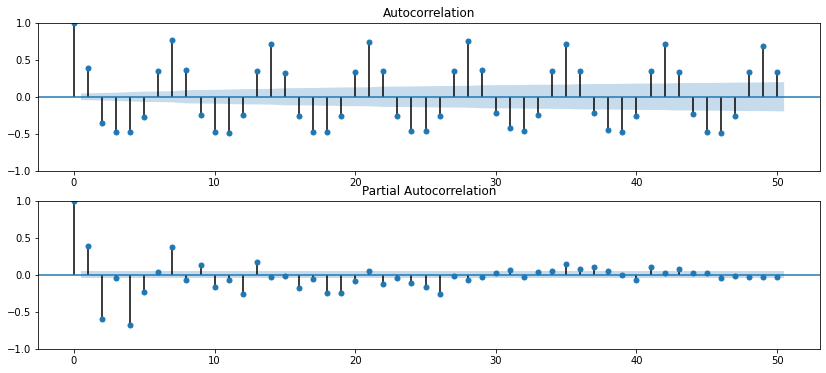

Results of Dickey-Fuller Test for :  HOBBIES
Test Statistic                -1.456485e+01
p-value                        4.730040e-27
#Lags Used                     2.600000e+01
Number of Observations Used    1.913000e+03
Critical Value (1%)           -3.430000e+00
Critical Value (5%)           -2.860000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64
++++++++++++++++++++++++++++++++++++++




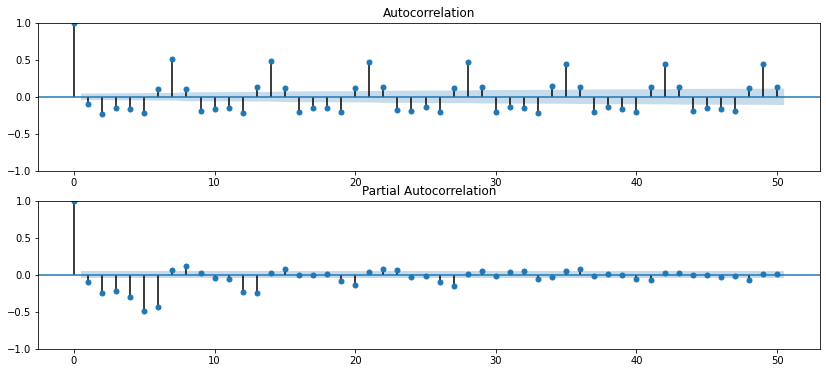

In [ ]:
lists = [sales_cat_food_diff,sales_cat_food_diff,sales_cat_hobbies_diff]
for i in lists:

  print('Results of Dickey-Fuller Test for : ',i.name)
  dftest = adfuller(i)

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = round(value,2)

  print(dfoutput)
  print('++++++++++++++++++++++++++++++++++++++')
  print('\n')

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
  ax1 = plot_acf(i, lags=50, ax=ax1)
  ax2 = plot_pacf(i, lags=50, ax=ax2)
  plt.show()

## Train ARIMA

In [ ]:
# Perform Train Test Splits
train = sales_cat_daily[:int(0.98*(len(sales_cat_daily)))]
test = sales_cat_daily[int(0.98*(len(sales_cat_daily))):]

### FOODS

In [ ]:
sales_cat_daily.FOODS.describe()

count     1941.000000
mean     23659.158681
std       4958.106999
min         11.000000
25%      20386.000000
50%      23272.000000
75%      26782.000000
max      41447.000000
Name: FOODS, dtype: float64

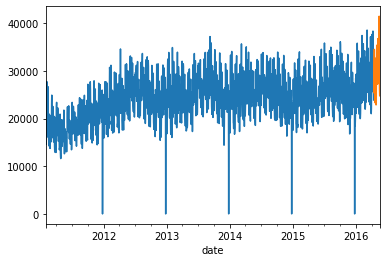

In [ ]:
train.FOODS.plot()
test.FOODS.plot()

In [ ]:
transformLog_flag = True

In [ ]:
# Train using Auto Arima
model_food = trainAutoARIMA(train.copy(),'FOODS', logTransformation = transformLog_flag)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5149.783, Time=0.36 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4131.857, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5149.783, Time=0.40 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3662.713, Time=0.41 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3399.206, Time=0.62 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3231.207, Time=0.79 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3110.768, Time=1.03 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.85 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=3110.768, Time=1.05 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0] intercept
Total fit time: 20.142 seconds


In [ ]:
[rmse_foods, results_foods] = evaluate_arima_model(train.copy(), test.copy(), model_food.get_params()['order'], 
                                                   'FOODS', logTransformation = transformLog_flag)
print(rmse_foods)

In [ ]:
modelSummary(sales_cat_daily, test, 'FOODS', results_foods, showConf=False, logTransformation = transformLog_flag)

In [ ]:
# Train using gridsearch

# parameters
p_values = range(0,6)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

results_foods_gs = trainARIMAGridSearch(train.copy(), test.copy(), 'FOODS',p_values,d_values,
                                        q_values,logTransformation = transformLog_flag)

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'FOODS', results_foods_gs, 
             showConf=False, logTransformation = transformLog_flag)

### HOBBIES

In [ ]:
sales_cat_daily.HOBBIES.describe()

count    1941.000000
mean     3215.175683
std       713.553574
min         0.000000
25%      2700.000000
50%      3188.000000
75%      3648.000000
max      5360.000000
Name: HOBBIES, dtype: float64

In [ ]:
train.HOBBIES.plot()
test.HOBBIES.plot()

In [ ]:
transformLog_flag = False

In [ ]:
model_hobbies = trainAutoARIMA(train.copy(), 'HOBBIES', logTransformation = transformLog_flag)

In [ ]:
[rmse_hobbies, results_hobbies] = evaluate_arima_model(train.copy(), test.copy(), model_hobbies.get_params()['order'], 
                                                       'HOBBIES', logTransformation = transformLog_flag)
print(rmse_hobbies)

In [ ]:
modelSummary(sales_cat_daily, test.copy(), 'HOBBIES', results_hobbies, 
             showConf=False, logTransformation = transformLog_flag)

In [ ]:
# Train using gridsearch

# parameters
p_values = range(0,7)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

results_hobbies_gs = trainARIMAGridSearch(train.copy(), test.copy(), 'HOBBIES',p_values,d_values,q_values, logTransformation = transformLog_flag)

In [ ]:
modelSummary(sales_cat_daily, test.copy(), 'HOBBIES', results_hobbies_gs, 
             showConf=False, logTransformation = transformLog_flag)

### HOUSEHOLD

In [ ]:
sales_cat_daily.HOUSEHOLD.describe()

count     1941.000000
mean      7606.434827
std       2209.606572
min          0.000000
25%       6088.000000
50%       7457.000000
75%       8998.000000
max      13889.000000
Name: HOUSEHOLD, dtype: float64

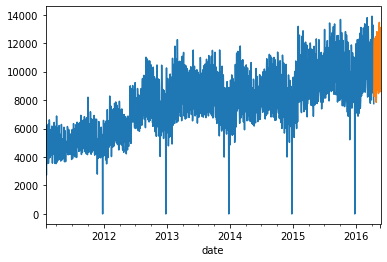

In [ ]:
train.HOUSEHOLD.plot()
test.HOUSEHOLD.plot()

In [ ]:
transformLog_flag = False

In [ ]:
model_household = trainAutoARIMA(train.copy(), category='HOUSEHOLD', logTransformation = transformLog_flag)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=34273.418, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=34128.148, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=34273.418, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=33923.781, Time=0.33 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=33848.141, Time=0.47 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=33761.146, Time=0.53 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=33180.432, Time=0.92 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.91 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=33180.432, Time=0.95 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0] intercept
Total fit time: 17.288 seconds


In [ ]:
[rmse_household, results_household] = evaluate_arima_model(train.copy(), test.copy(), model_household.get_params()['order'],
                                                           'HOUSEHOLD', logTransformation = transformLog_flag)
print(rmse_household)

In [ ]:
modelSummary(sales_cat_daily, test.copy(), 'HOUSEHOLD', results_household, 
             showConf=False, logTransformation = transformLog_flag)

In [ ]:
# Train using gridsearch

# parameters
p_values = range(0,7)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

results_household_gs = trainARIMAGridSearch(train.copy(), test.copy(), 'HOUSEHOLD',p_values,d_values,
                                            q_values, logTransformation = transformLog_flag)

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOUSEHOLD', results_household_gs, 
             showConf= False, logTransformation = transformLog_flag)

## SARIMAX Training

In [ ]:
train = sales_cat_daily[:int(0.98*(len(sales_cat_daily)))]
test = sales_cat_daily[int(0.98*(len(sales_cat_daily))):]

### FOODS

In [ ]:
transformLog_flag = True

In [ ]:
sarima_model_foods = trainSeasonalAutoARIMA(train.copy(),'FOODS', logTransformation = transformLog_flag)

In [ ]:
# Extract Model Parameters
order = sarima_model_foods.get_params()['order']
seasonal_order = sarima_model_foods.get_params()['seasonal_order']
trend = sarima_model_foods.get_params()['trend']

model_params = [order, seasonal_order, trend]
model_params

In [ ]:
[rmse_sarima_foods, smodel_foods] = evaluate_seasonal_arima_model(train.copy(), test.copy(), model_params,
                                                                  'FOODS', logTransformation = transformLog_flag)
print(rmse_sarima_foods)

In [ ]:
modelSummary(sales_cat_daily, test.copy(), 'FOODS', smodel_foods, model="sarimax", 
             showConf=False, logTransformation = transformLog_flag)

### HOBBIES

In [ ]:
transformLog_flag = True

In [ ]:
sarima_model_hobbies = trainSeasonalAutoARIMA(train.copy(),'HOBBIES',tr='c', logTransformation = transformLog_flag)

In [ ]:
# Extract Model Parameters
order = sarima_model_hobbies.get_params()['order']
seasonal_order = sarima_model_hobbies.get_params()['seasonal_order']
trend = sarima_model_hobbies.get_params()['trend']

model_params = [order, seasonal_order, trend]
model_params

In [ ]:
[rmse_sarima_hobbies, smodel_hobbies] = evaluate_seasonal_arima_model(train.copy(), test.copy(), model_params,
                                                                      'HOBBIES', logTransformation = transformLog_flag)
print(rmse_sarima_hobbies)

In [ ]:
modelSummary(sales_cat_weekly, test.copy(), 'HOBBIES', smodel_hobbies, model="sarimax", 
             showConf=False, logTransformation = transformLog_flag)

In [ ]:
# define config lists
p_params = [1, 2, 3, 4, 5]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
t_params = ['n','c','t']
P_params = [0, 1, 2, 3]
D_params = [0, 1]
Q_params = [0, 1, 2, 3]

# smodel_hobbies_gs = trainSeasonalARIMAGridSearch(train.copy(), test.copy(), 'HOBBIES', p_params, d_params, q_params, t_params, 
#                                                  P_params, D_params, Q_params, logTransformation = transformLog_flag)

In [ ]:
#modelSummary(sales_cat_daily, test, 'HOBBIES', smodel_hobbies_gs, model="sarimax", logTransformation = transformLog_flag)

### HOUSEHOLD

In [ ]:
transformLog_flag = False

In [ ]:
sarima_model_household = trainSeasonalAutoARIMA(train.copy(),'HOUSEHOLD',tr='c', logTransformation = transformLog_flag)

In [ ]:
# Extract Model Parameters
order = sarima_model_household.get_params()['order']
seasonal_order = sarima_model_household.get_params()['seasonal_order']
trend = sarima_model_household.get_params()['trend']

model_params = [order, seasonal_order, trend]
model_params

In [ ]:
[rmse_sarima_household, smodel_household] = evaluate_seasonal_arima_model(train.copy(), test.copy(), model_params,
                                                                          'HOUSEHOLD', logTransformation = transformLog_flag)
print(rmse_sarima_household)

In [ ]:
modelSummary(sales_cat_daily, test.copy(), 'HOUSEHOLD', smodel_household, model="sarimax",
             showConf=False, logTransformation = transformLog_flag)

In [ ]:
# define config lists
p_params = [1, 2, 3, 4, 5]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
t_params = ['n','c','t']
P_params = [0, 1, 2, 3]
D_params = [0, 1]
Q_params = [0, 1, 2, 3]

# smodel_household_gs = trainSeasonalARIMAGridSearch(train.copy(), test.copy(), 'HOUSEHOLD', p_params, d_params, q_params, t_params,
#                                                    P_params, D_params, Q_params, logTransformation = transformLog_flag)

In [ ]:
#modelSummary(sales_cat_daily, test.copy(), 'HOUSEHOLD', smodel_household_gs, model="sarimax", logTransformation = transformLog_flag)